# Forecasting organic growth

## Imports

In [1]:
PATH_OUT = '/Users/ahmed/Projects/gm_tool/assets/'

In [1]:
import sys
import pandas as pd
import datetime as dt
import numpy as np
import time

from itertools import product
from pytrends.request import TrendReq as UTrendReq
import requests

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(); sns.set_style('whitegrid')

from prophet import Prophet
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

from tqdm.notebook import tqdm
from IPython.display import display, HTML

sys.path.insert(0,"/Users/ahmed/Projects/gm_tool/")
from datamanager.DM_USA import DM_USA

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Preprocessing 

In [2]:
country = "USA"
brands_name = {"BELGIUM": ["APERICUBE", "BABYBEL", "BOURSIN", "KIRI", "MINI BABYBEL", "VACHE QUI RIT", "MAREDSOUS"],
     "USA": ["BABYBEL", "THE LAUGHING COW", "BOURSIN", "KAUKAUNA", "MERKTS", "PRICES", "NURISHH"]}
aandp_brands_name = {"BELGIUM": ["APERICUBE", "BABYBEL", "BOURSIN", "KIRI", "MINI BABYBEL", "VACHE QUI RIT", "MAREDSOUS"],
    "USA": ["000BQ - BOURSIN", "000LA - THE LAUGHING COW", "000MB - MINI BABYBEL", "000KC - KAUKAUNA", "000PG - PRICE'S", "000MI - MERKTS", "003NH - NURISHH"]}
features = ["Date", "Brand", "Category", "Distribution", "Price per volume", "Sales in volume"]

In [4]:
# Loading dataframe using datamanager
data_manager = DM_USA(brands_name[country], aandp_brands_name[country])
df_bel = data_manager.get_df_bel()
df = data_manager.get_df()
df.head()
df_bel.head()

page 1/14
page 2/14
page 3/14
page 4/14
page 5/14
page 6/14
page 7/14
page 8/14
page 9/14
page 10/14
page 11/14
page 12/14
page 13/14
page 14/14


/Users/ahmed/Projects/gm_tool/datamanager/DM_USA.py:71: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  ['Date', 'Brand'], as_index=False)['Distribution', 'Price per volume', 'Sales in volume'].agg(


columns and types are correct


,Date,Category,Sub Category,Brand,Sales in value,Sales in volume,Distribution,Price per volume,Price without promo,Sales value with promo,Sales volume with promo,Period
0,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,285.014421,25.961137,0.013007,10.978503,10.978503,NaN,NaN,1
1,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,AUTHENTIC MENU,1205.790000,242.500000,1.980134,4.972330,4.994717,5.277200,2.145000,1
2,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,APPEL FARM QUARK,391.079899,80.904125,0.151621,4.833868,4.966977,4.796178,2.756167,1
3,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,ASHBYS,3909.132137,327.681769,0.848531,11.929660,12.025146,53.182613,6.832235,1
4,2017-12-31,CLASSIC SPREADS,CLASSIC SPREADS,NEW BRIDGE,27112.449008,2707.353139,7.551650,10.014375,10.455282,995.316059,184.093633,1


,Date,Brand,Distribution,Price per volume,Sales in volume,A&P,Rate of Innovation,Promo Cost,HH
0,2017-12-31,BABYBEL,417.403475,11.307482,250446.559440,NaN,0.0,NaN,NaN
1,2017-12-31,BOURSIN,152.671400,13.745852,85626.196096,NaN,0.0,NaN,NaN
2,2017-12-31,KAUKAUNA,173.182554,6.703015,444672.382865,NaN,0.0,NaN,NaN
3,2017-12-31,MERKTS,77.224967,5.383924,88166.774383,NaN,0.0,NaN,NaN
4,2017-12-31,PRICES,93.366316,4.762444,108331.433158,NaN,0.0,NaN,NaN


In [ ]:
df = pd.read_excel('data/USA/USA_df_postprocessing_0303.xlsx')

In [3]:
df_bel = pd.read_excel('data/USA/USA_df_bel_0303.xlsx')

In [7]:
df.describe()
df_bel.describe()

,Sales in value,Sales value with promo,Sales in volume,Sales volume with promo,Price without promo,Price with promo,Price per volume,Distribution,Period
count,5.618450e+05,3.319400e+05,5.616510e+05,3.319140e+05,556360.000000,331914.000000,561651.000000,561851.000000,561851.000000
mean,1.560801e+05,2.536450e+04,3.050336e+04,7.183366e+03,10.998721,9.323602,10.724612,15.021705,104.071197
std,1.731295e+06,2.640968e+05,4.292492e+05,8.477446e+04,6.966822,5.689281,6.838948,111.353966,59.940493
min,1.059592e-02,-2.061822e+04,3.374096e-03,0.000000e+00,0.004545,0.020000,0.004545,0.000008,1.000000
25%,5.094914e+02,1.630839e+01,5.169279e+01,3.122572e+00,5.926933,5.190934,5.757340,0.057040,52.000000
50%,2.518780e+03,1.833527e+02,2.896750e+02,3.065530e+01,8.990000,7.929900,8.728550,0.304649,104.000000
75%,1.424689e+04,1.576589e+03,1.622736e+03,2.810669e+02,14.256434,11.980000,13.936014,2.112577,156.000000
max,1.080815e+08,2.069495e+07,2.791777e+07,5.769725e+06,111.840000,111.840000,111.840000,3286.000649,209.000000


,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH
count,1290.000000,1290.000000,1.290000e+03,1290.000000,1.284000e+03,1284.000000,1284.000000,1.284000e+03,1.284000e+03,1254.000000,9.720000e+02,1248.000000
mean,9.711234,162125.343108,1.466125e+06,112.370019,1.042795e+06,468.563419,180.197304,1.483993e+05,3.517348e+05,0.056198,1.311533e+05,0.118627
std,3.934358,130600.480349,1.413531e+06,79.900971,1.168932e+06,751.997698,229.443496,2.079499e+05,5.032372e+05,0.167690,1.995524e+05,0.131695
min,4.356190,33.244110,4.593722e+02,0.106678,-1.306417e+03,0.000000,0.476932,5.590334e+02,-2.230124e+03,0.000000,0.000000e+00,0.000000
25%,6.656784,59169.502380,5.304450e+05,59.829339,2.595571e+05,7.020648,24.314749,1.002405e+04,2.979779e+02,0.000000,1.162927e+04,0.000000
50%,8.214918,110994.645919,7.593131e+05,91.803154,4.935925e+05,98.394032,80.457900,4.787216e+04,1.032955e+05,0.000000,3.496581e+04,0.085845
75%,13.127200,247810.062772,2.009003e+06,144.134090,1.256272e+06,587.111062,253.779553,1.999614e+05,5.255385e+05,0.044170,1.753168e+05,0.207211
max,18.750507,634634.168587,6.431016e+06,453.794758,4.899662e+06,3834.525990,1405.353723,1.039757e+06,2.278523e+06,0.945625,1.363849e+06,0.635718


Dictionary of brand's markets.

In [8]:
brands_markets = {brand: df[df.Brand == brand].Category.unique().tolist() for brand in brands_name[country]}
bel_markets = list(set([elem for brand in brands_markets for elem in brands_markets[brand]]))
brands_markets
bel_markets

{'BABYBEL': ['SNACK', 'SNACKING COMBOS'],
 'THE LAUGHING COW': ['CLASSIC SPREADS', 'SNACK', 'SNACKING COMBOS'],
 'BOURSIN': ['GOURMET SPREADS', 'PLANT BASED'],
 'KAUKAUNA': ['CLASSIC SPREADS', 'GOURMET SPREADS', 'SNACK'],
 'MERKTS': ['CLASSIC SPREADS', 'SNACK'],
 'PRICES': ['PIMENTO', 'SNACK'],
 'NURISHH': ['PLANT BASED']}

['PIMENTO',
 'PLANT BASED',
 'CLASSIC SPREADS',
 'SNACKING COMBOS',
 'SNACK',
 'GOURMET SPREADS']

In [63]:
df.head()

,Date,Market,Category,Sub Category,Brand,Sales in value,Sales value with promo,Sales in volume,Sales volume with promo,Price without promo,Price with promo,Price per volume,Distribution,Period
0,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,1000 ISLANDS RIVER RAT CHEESE,285.014421,NaN,25.961137,NaN,10.978503,NaN,10.978503,0.013007,1
1,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,AUTHENTIC MENU,1205.790000,5.277200,242.500000,2.145000,4.994717,3.637500,4.972330,1.980134,1
2,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,APPEL FARM QUARK,391.079899,4.796178,80.904125,2.756167,4.966977,3.365000,4.833868,0.151621,1
3,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,ASHBYS,3909.132137,53.182613,327.681769,6.832235,12.025146,10.709200,11.929660,0.848531,1
4,2017-12-31,CHEESE,CLASSIC SPREADS,CLASSIC SPREADS,NEW BRIDGE,27112.449008,995.316059,2707.353139,184.093633,10.455282,8.365867,10.014375,7.551650,1


In [15]:
def get_df_brands(data_manager, country, brands_name, features):
    """Get the right DataFrame giving the country, the brands and features 
    from the datamanager
    """
    df_res = df[df.Brand.isin(
        brands_name[country])][features]
    df_res = df_res.fillna(0)

    return df_res

def get_df_competition_brands(df, brands_name, features):
    """Get the dataframe of all the other brands except the given ones with 
    the specified features
    """
    df_res = df[~(df.Brand.isin(
        brands_name)) & (df.Category.isin(
        bel_markets))][features]
    df_res = df_res.fillna(0)
    
    return df_res

def get_df_markets(df):
    """Get Markets dataframe
    """
    df_res = df.groupby(['Category', 'Date']).agg("sum")[
        ['Sales in volume']].unstack(0)
    df_res = df_res.droplevel(level=0, axis=1).reset_index()
    df_res['TOTAL CHEESE'] = df_res.iloc[:, 1:].sum(axis=1)
    df_res = df_res.fillna(0)
    df_res.columns.name = ''

    return df_res

def forecasting_features(df, features, periods=36, freq='MS'):
    """Get long term forecasts for features giving the dataframe and periods
    """
    # Select features except the target
    list_df_features = []
    for feature in tqdm(features, ascii=True, desc='Features'):
        model = Prophet()
        # Preprocessing Inputs of Prophet
        df_frcast = df[['Date', feature]]
        df_frcast.columns = ['ds', 'y']
        df_frcast.ds = pd.to_datetime(df_frcast.ds)
        df_frcast['cap'] = df[feature].max() * 3
        df_frcast['floor'] = df[feature].mean() / 2
        # Model
        model = Prophet(growth='logistic', yearly_seasonality=20)
        model.fit(df_frcast)

        # Periods is in months
        future = model.make_future_dataframe(periods=periods, freq=freq)
        future['cap'] = df[feature].max() * 3
        future['floor'] = df[feature].mean() / 2
        fcst = model.predict(future[future.ds > df_frcast.ds.iloc[-1]])
        model.plot(fcst)
        df_frcast.rename(columns={'y': feature}, inplace=True)
        fcst.rename(columns={'yhat': feature}, inplace=True)
        # Adding result to list
        list_df_features.append(pd.concat([df_frcast.iloc[:, :-2], fcst[['ds', feature]]]))

    # Merging the dataframes of each feature
    df_features = list_df_features[0][['ds']]
    for dff in list_df_features:
        df_features = pd.merge(df_features, dff, on='ds')

    df_features.rename(columns={'ds': 'Date'}, inplace=True)
    return df_features


def forecasting_one_brand(df, brand_name, features_name, periods=36, freq='MS'):
    """ Forecasting giving brand_name for giving number of periods and 
    features to use. 
    """
    # Get DataFrame for brand_name
    df = df.groupby(["Brand", "Date"]).agg(
        "sum").loc[brand_name].reset_index().sort_values('Date')
    
    # Predict long-term forecast for features
    df_features = forecasting_features(df, features_name, periods=periods, freq=freq)
    # Preprocessing dataframe for prophet
    df['Date'] = pd.to_datetime(df.Date)
    #df = pd.merge(df_features_train, df[['Date', 'Sales in volume']], on='Date', how='inner')
    df = df[['Date', *features_name, 'Sales in volume']]
    df.rename(columns={'Date': 'ds', 'Sales in volume': 'y'}, inplace=True)
    
    # Instanciating Prophet Model
    model = Prophet(growth='logistic', yearly_seasonality=20)
    df['cap'] = df['y'].max() * 3
    df['floor'] = df['y'].min() / 2
    if (df['cap'] <= df['floor']).any():
        df['cap'] = df.floor + 1
        
    # Adding regressors
    for feature in features_name:
        model.add_regressor(feature)

    # Fitting model
    model.fit(df)
    
    future = model.make_future_dataframe(periods=periods, freq=freq)
    future['cap'] = df['cap'][0]
    future['floor'] = df['floor'][0]
    
    if brand_name == "PRICES":
        future['floor'] = 95000
        
    for feature in features_name:
        future[feature] = df_features[feature]

    # Predicting sales forecasts
    fcst = model.predict(future[future.ds > df.ds.iloc[-1]])
    fcst.rename(columns={'yhat':'y'}, inplace=True)
    df_brand_fcst = pd.concat([df[['ds', 'y']], fcst[['ds', 'y']]])
    df_brand_fcst.rename(columns={'ds': 'Date', 'y':brand_name}, inplace=True)
    # df_brand_fcst = pd.DataFrame()
    # df_brand_fcst["Date"] = df_features["Date"]
    # df_brand_fcst[brand_name+" Sales in volume"] = fcst["yhat"]

    return future, df_brand_fcst


def forecasting_brands(df, brands_name, features_name, periods=36, freq='MS'):
    """Forecasting a list of brands using the given features and periods
    """

    dict_feats_futures = {}
    list_df_brands = []
    # Compute forecast for each brand
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        future, brand_fcst = forecasting_one_brand(df, brand, features_name, periods=periods, freq=freq)
        dict_feats_futures[brand] = future
        list_df_brands.append(brand_fcst)

    # Merge results of each brand
    df_brands_fcst = list_df_brands[0].Date
    for df_tmp in list_df_brands:
        df_brands_fcst = pd.merge(df_brands_fcst, df_tmp, on='Date', how='outer')

    return dict_feats_futures, df_brands_fcst


def forecasting_markets(df, markets_name, periods=36, freq='MS'):
    """Forecasting list of markets for the given periods
    """
    df_features = forecasting_features(df, markets_name, periods=periods, freq=freq)

    return df_features

def mitigate_covid(df, features, dates):
    """
    """
    pass
    
# Get adjusted features for organic growth
def adjust_organic_growth_features(df_features):
    """Adjust organic growth features for computing correlation of growth
    Drivers in the future (forecast)
    """
    df_organicforecast_feature = df_features.copy()
    feature_columns = list(df_organicforecast_feature)[1:]
    controlable_features = feature_columns[:4]
    df_organic_forecast_feature["Distribution"] = 0
    df_organic_forecast_feature["Rate of innovation"] = 0
    price_75percentile = df_organic_forecast_feature["Price per volume"].quantile(
        0.75)
    df_organic_forecast_feature["Price per volume"] = df_organic_forecast_feature["Price per volume"].apply(
        lambda x: x*1.25 if x <= price_75percentile else x)
    TDP_75percentile = df_organic_forecast_feature["TDP"].quantile(0.75)
    df_organic_forecast_feature["TDP"] = df_organic_forecast_feature["TDP"].apply(
        lambda x: x*0.75 if x >= TDP_75percentile else x)
    
    return df_organic_forecast_feature

In [153]:
df_tmp_bel = df_bel.set_index('Date').loc["2019-01-01":"2021-12-31"]

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

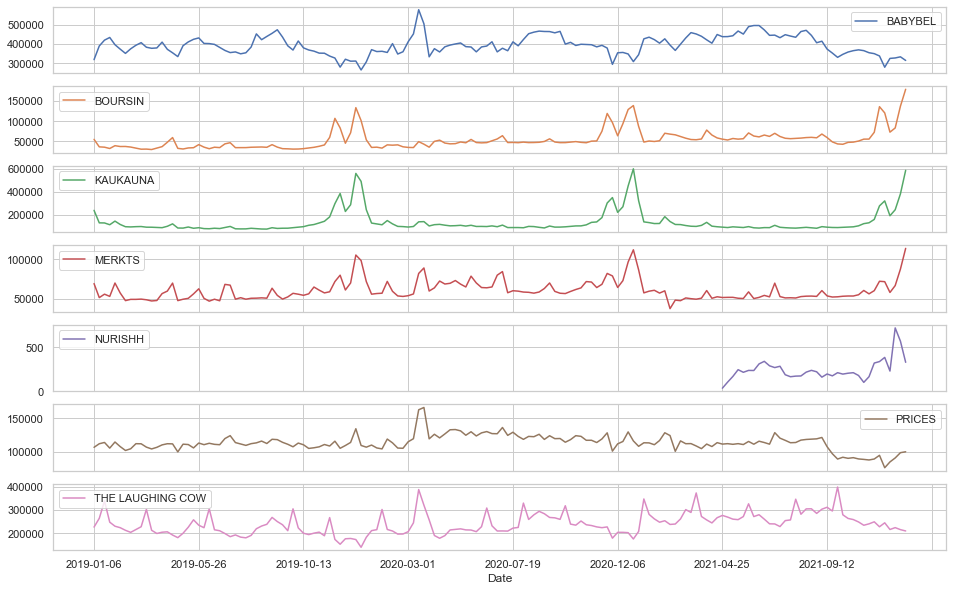

In [154]:
df_tmp_bel.reset_index().groupby(['Date', 'Brand']).agg('sum').unstack()['Sales in volume'].plot(subplots=True, figsize=(16, 10))

## Computing Trends

In [10]:
kw_list = brands_name[country]
timeframes = list(df_bel.Date.unique())
tdelta = dt.timedelta(weeks=1)
timeframes.insert(0, (dt.datetime.strptime(timeframes[0], '%Y-%m-%d') - tdelta).strftime('%Y-%m-%d'))
    
geo='US'
GET_METHOD='get'
headers = {
'authority': 'trends.google.com',
'cache-control': 'max-age=0',
'sec-ch-ua': '" Not A;Brand";v="99", "Chromium";v="98", "Google Chrome";v="98"',
'sec-ch-ua-mobile': '?0',
'sec-ch-ua-platform': '"macOS"',
'upgrade-insecure-requests': '1',
'user-agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/98.0.4758.102 Safari/537.36',
'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9',
'x-client-data': 'CJ7fygE=',
'sec-fetch-site': 'same-origin',
'sec-fetch-mode': 'navigate',
'sec-fetch-user': '?1',
'sec-fetch-dest': 'document',
'referer': 'https://trends.google.com/trends/?geo='+geo,
'accept-language': 'fr-FR,fr;q=0.9,en-US;q=0.8,en;q=0.7',
'cookie': '__utma=10102256.2142090120.1645455402.1645455402.1645455402.1; __utmc=10102256; __utmz=10102256.1645455402.1.1.utmcsr=(direct)|utmccn=(direct)|utmcmd=(none); __utmt=1; __utmb=10102256.5.9.1645455408893; CONSENT=YES+srp.gws-20220217-0-RC1.fr+FX+004; 1P_JAR=2022-02-21-15; SID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEa8TFYSMqHR-5OUrj7OtQx_A.; __Secure-1PSID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEawJmkuoBDtYla3S3m5hx8kQ.; __Secure-3PSID=HQgzK1_QHq5O4Gxfol7wNIQ8JBvuh_XBbe-63vwnERFhFJEaG7QfexXpqx5lg43EMUQUQw.; HSID=A_K65lvXgt3Scuc0n; SSID=Ajaw0EKPT7Ok638qm; APISID=1gdUaeoAbGY0hQBG/A68-B5BtWRxthyMoo; SAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; __Secure-1PAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; __Secure-3PAPISID=35kLI8C4oe7oZA-1/Ao42EJJT31v8K2hBe; NID=511=odIcinna2wJGUmMhN_uM0o_utTxPmkP7IP3WPOfwUDcgDxNaSaK0g-JdjZ15JWlWHpgSqsD2-DFJcy4-F8KfN5oGoz3dsqRKBpr0cgLmyefwq5Dsd2fLlSUh9HJhga7TaUfRKSdu09XitvJ8nCdnGN4iDLenCzdI5qEfyHyB3wJAZyONpYd-P1JtXD56OKnm-wJ5JoJObdm67M_myZj4PiOjMvOeVvnAMVHnZee48Ho; SIDCC=AJi4QfF7GP5rUgjZhMuSVECtziYI-TgFSUpdgGLTnDwYSuP22BrKzLUpdkcYO4aLQjG4jg09; __Secure-3PSIDCC=AJi4QfGKL18okfSNCPOhtb0IHAOOHOOROq_xm0P_hN0fwHW0il9jxtNj4ChDoxtjdexO_l6d',
}

class TrendReq(UTrendReq):
    def _get_data(self, url, method=GET_METHOD, trim_chars=0, **kwargs):
        return super()._get_data(url, method=GET_METHOD, trim_chars=trim_chars, headers=headers, **kwargs)

def compute_trends(geo, kw_list, timeframes):
    """
    """

    pytrend = TrendReq(hl=geo, tz=360)
    dataset = []
    for i in tqdm(range(1, len(timeframes)), desc='TimeFrames', ascii=True):
        # Merge kw queries results, only 5 max can be queried in an iteration
        tmp_data_raw = [timeframes[i]]
        for j in range(0, len(kw_list), 5):
            # 5: because only 5 keywords can be computed at the same time
            pytrend.build_payload(
                kw_list=kw_list[j:j+5],
                timeframe='{} {}'.format(timeframes[i-1], timeframes[i]), 
                geo=geo,
                gprop='')
            data = pytrend.interest_over_time().sum(axis=0)
            # [:-1] in order to not take into account the isPartial column 
            tmp_data_raw += list(data.values)[:-1]
        dataset.append(tmp_data_raw)

    df_trends = pd.DataFrame(dataset, columns=['Date'] + kw_list)
    return df_trends

def compute_trends_bis(geo, kw_list, start_date, end_date):
    """
    """
    pytrend = TrendReq(hl=geo, tz=360)
    dataset = pd.DataFrame()
    for i in range(0, len(kw_list), 5):
        pytrend.build_payload(
            kw_list=kw_list[i:i+5],
            timeframe='{} {}'.format(start_date, end_date),
            geo=geo,
            gprop=''
        )
        data = pytrend.interest_over_time()
        dataset = pd.concat([dataset, data.iloc[:, :-1]], axis=1)
        
    return dataset

In [11]:
df_trends = compute_trends_bis('US', kw_list, start_date=timeframes[0], end_date=timeframes[-1])
df_trends = df_trends.reset_index().rename(columns={'date':'Date'})
df_trends.head()

,Date,BABYBEL,THE LAUGHING COW,BOURSIN,KAUKAUNA,MERKTS,PRICES,NURISHH
0,2017-12-24,15,3,37,51,1,77,0
1,2017-12-31,19,3,24,40,1,74,0
2,2018-01-07,21,2,17,51,1,72,0
3,2018-01-14,21,2,18,51,0,73,0
4,2018-01-21,23,1,16,52,1,72,0


In [ ]:
df_trends.to_csv('../data/brand_trends_usa.csv')

## Forecasting Brands

### No regressors

Features:   0%|          | 0/7 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -13.4653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       424.802   0.000947532       76.4268    8.61e-06       0.001      112  LS failed, Hessian reset 
      99       424.971   0.000470374       83.2883           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       425.017   2.40555e-09       68.4496     0.08797           1      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -30.2846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       554.829   0.000140963       81.0577      0.3443           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       555.273   1.49113e-05       89.5837      0.5649      0.5649      261   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       555.496   4.67579e-09           104    0.006373           1      373   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -51.7616
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       606.717    0.00582027       106.449      0.3289           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       607.047   6.15838e-08       87.3814       0.294           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       607.047   2.31588e-08       82.9957      0.2118           1      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -24.5185
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.416       0.02875       93.4409           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        450.47    0.00154916       81.4952   1.778e-05       0.001      219  LS failed, Hessian reset 
     199       450.773   7.22196e-06       55.5532        0.54        0.54      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       450.781   5.55234e-05       72.0868   8.817e-07       0.001      364  LS failed, Hessian reset 
     246       450.785   7.73995e-09       63.2216     0.07894     0.07894      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -4.99862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.947   0.000966106       101.324      0.7224      0.7224      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       445.065   0.000945514       102.276   9.266e-06       0.001      169  LS failed, Hessian reset 
     157       445.198   9.32515e-09       96.9001      0.4879      0.4879      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -5.82129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        419.69    0.00616956       52.7236      0.7699      0.7699      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       420.181   0.000212444       87.9558   2.923e-06       0.001      205  LS failed, Hessian reset 
     175       420.254   7.24643e-05       37.4604   1.653e-06       0.001      317  LS failed, Hessian reset 
     197       420.267   8.67571e-07       32.7913    2.28e-08       0.001      386  LS failed, Hessian reset 
     199       420.267   2.92696e-07       39.3813      0.3696           1      389   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       420.267   2.41532e-07       38.2909   4.511e-09       0.001      451  LS failed, Hessian reset 
     224       420.267   7.09824e-08        32.743   1.596e-09   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -9.31985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       336.615   0.000478193       70.6454   5.573e-06       0.001      194  LS failed, Hessian reset 
      99       336.625   6.08558e-05       67.2183      0.7859      0.7859      199   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       336.632   5.01774e-06       64.2643   6.887e-08       0.001      286  LS failed, Hessian reset 
     161       336.632   1.74526e-08        66.964      0.1721           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


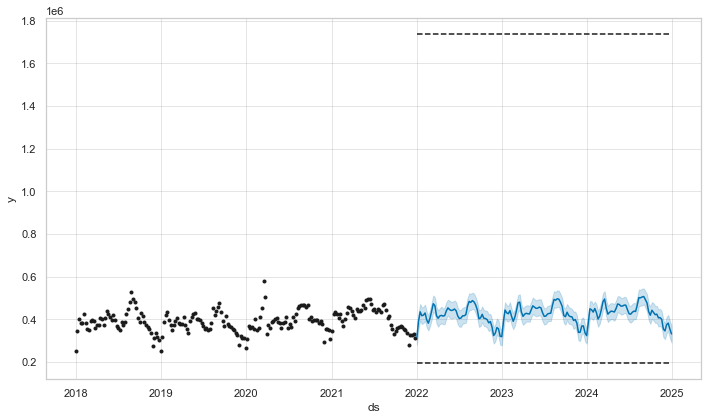

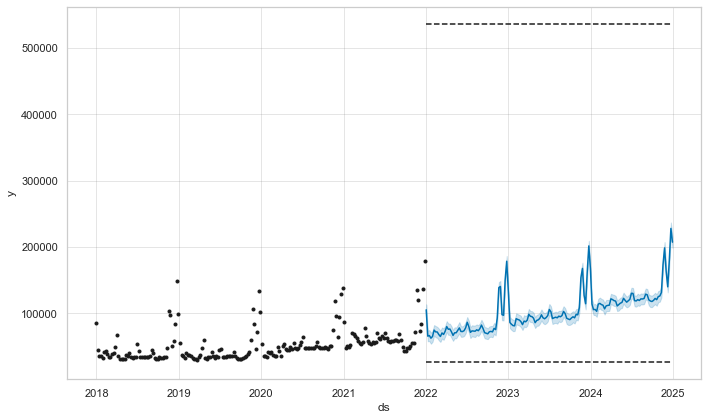

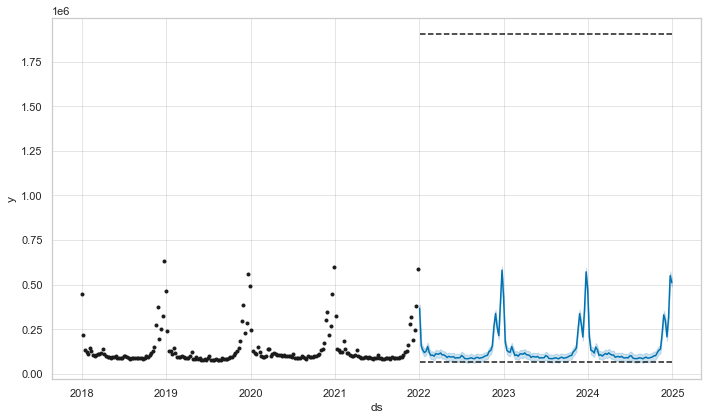

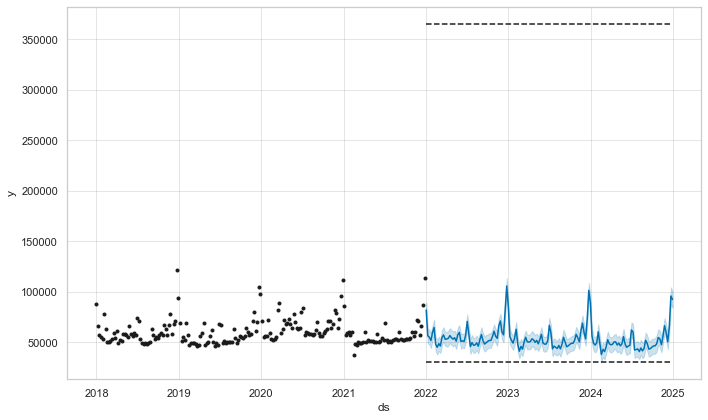

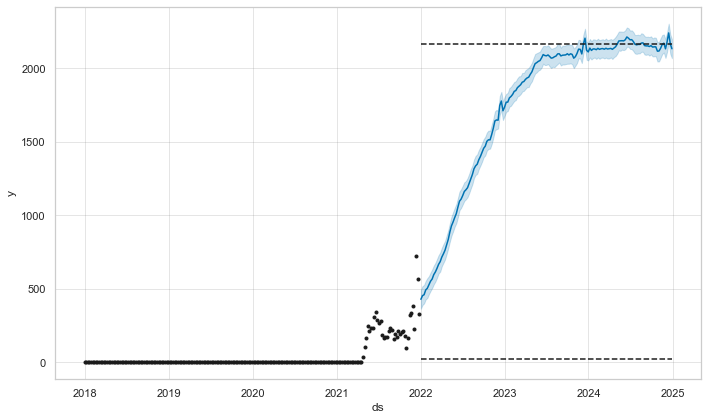

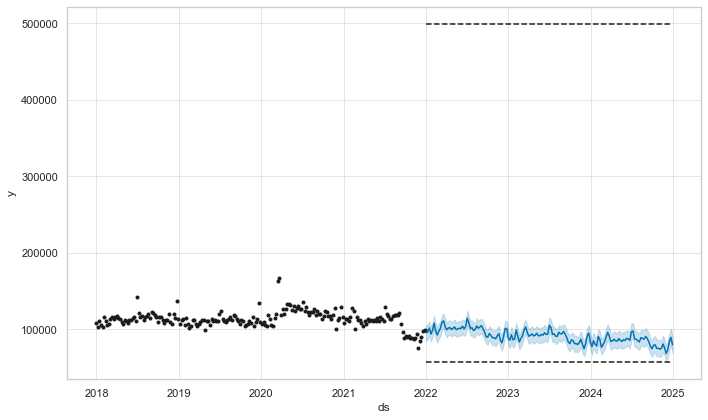

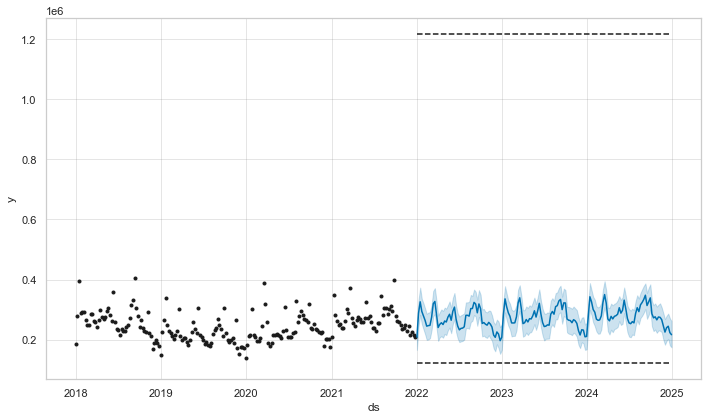

In [12]:
df_bel_brands = df_bel.groupby(["Date", "Brand"]).agg('sum')['Sales in volume'].unstack().reset_index()
df_bel_brands.columns.name=''
df_bel_brands = df_bel_brands.fillna(0)
df_bel_brands_fcst_res = forecasting_features(df_bel_brands, list(df_bel_brands.columns[1:]), periods=157, freq='W')

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

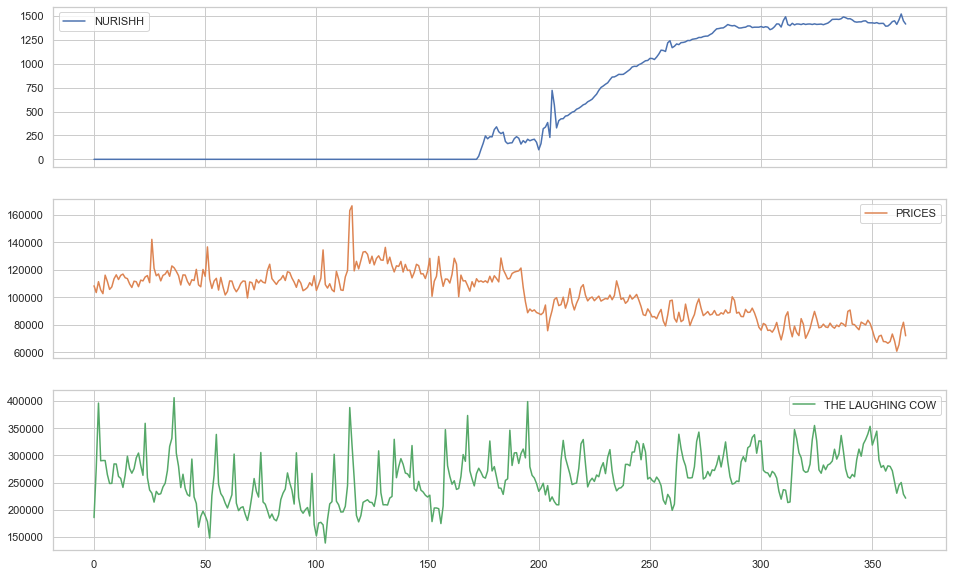

In [176]:
df_bel_brands_fcst_res.iloc[:, 5:].plot(subplots=True, figsize=(16, 10))

In [185]:
df_bel_brands_fcst_res['Date'] = df_bel_brands_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_bel_brands_fcst_res.round(1).to_excel("results/usa_brands_forecasts_no_regressors.xlsx", index=False)

### With Regressors

In [13]:
df_bel['Trends'] = df_bel.apply(lambda x: df_trends[df_trends.Date == x.Date][x.Brand].values[0], axis=1)
df_bel.fillna(0, inplace=True)
df_bel.head()

,Date,Brand,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH,Trends
0,2017-12-31,BABYBEL,11.307482,250446.559440,2.831920e+06,417.403475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
1,2017-12-31,BOURSIN,13.745852,85626.196096,1.177005e+06,152.674082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
2,2017-12-31,KAUKAUNA,6.703015,444672.382865,2.792992e+06,173.183200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,2017-12-31,MERKTS,5.383924,88166.774383,4.746832e+05,77.224967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2017-12-31,PRICES,4.762444,108331.433158,5.159224e+05,93.366316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -16.6896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69        225.69    0.00103699       64.5948   2.215e-05       0.001      143  LS failed, Hessian reset 
      99       225.831    0.00129259       77.1333           1           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       226.193    0.00130166       92.8605           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205        226.23   0.000500953       78.3627   7.089e-06       0.001      377  LS failed, Hessian reset 
     280       226.323   2.14302e-07       79.0953   4.012e-09       0.001      513  LS failed, Hessian reset 
     288       226.323   5.77612e-09       54.2581      0.2599           1      525   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.49177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       460.372    0.00195852       73.1924   2.066e-05       0.001      142  LS failed, Hessian reset 
      99       460.451   1.33744e-05       72.7796      0.4268           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       460.557   0.000944355       83.0627   1.012e-05       0.001      307  LS failed, Hessian reset 
     199       460.597   1.86138e-05        73.089      0.8876      0.8876      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       460.599   3.81338e-08       62.7085      0.3925      0.3925      393   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -186.93
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       64.9142   0.000334343       90.5583   3.875e-06       0.001      164  LS failed, Hessian reset 
      99       64.9313   8.35335e-06       79.8939      0.8357      0.8357      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       64.9316    6.4027e-09       78.9775     0.08666     0.08666      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -5.28598
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       319.618    0.00334056       66.5065   4.023e-05       0.001       75  LS failed, Hessian reset 
      74        320.34    0.00394943        86.812   4.485e-05       0.001      162  LS failed, Hessian reset 
      99       320.688   5.43839e-06       77.8302      0.4374      0.4374      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       324.038    0.00544076       84.9955   5.873e-05       0.001      338  LS failed, Hessian reset 
     199        324.53   2.68939e-06       72.7914      0.4736      0.4736      376   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        324.53   8.62002e-09       72.7107      0.2741      0.2741      414   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.3041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57        470.41   0.000647794       61.7705   1.005e-05       0.001      111  LS failed, Hessian reset 
      94       470.446   4.30435e-05       66.9212   6.286e-07       0.001      201  LS failed, Hessian reset 
      99       470.448   1.17572e-05        58.638       2.697           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       470.448   8.71803e-09       54.6438      0.2168           1      255   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -193.546
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99     -0.787176   1.85611e-05        80.886           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125     -0.764291   0.000146379       89.4797   1.703e-06       0.001      208  LS failed, Hessian reset 
     178     -0.754819   3.93997e-07       89.6709   5.089e-09       0.001      320  LS failed, Hessian reset 
     193     -0.754797   3.30604e-09       68.1329       0.375       0.375      339   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -8.73878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       371.261   2.64716e-05       91.7698           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       371.264   2.61478e-06       65.9807   3.726e-08       0.001      201  LS failed, Hessian reset 
     138       371.264   1.70097e-08       64.2461      0.5561      0.5561      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -61.1147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       236.876   1.53375e-05       102.336           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       236.876   1.24659e-06       95.4465   1.218e-08       0.001      192  LS failed, Hessian reset 
     118       236.876   9.25102e-09       91.4018      0.5647      0.5647      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -14.5745
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       153.219   8.13729e-07       81.4541   9.404e-09       0.001      170  LS failed, Hessian reset 
      99       153.219    1.9485e-07       75.9963      0.6848      0.6848      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       153.219    8.6755e-09       79.9705      0.5193      0.5193      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.42486
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.838   0.000458636       71.7829           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       469.885   0.000497225       87.9834     7.3e-06       0.001      169  LS failed, Hessian reset 
     199       469.969   2.40546e-05       63.9731       2.038      0.4163      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       470.001    4.0834e-05       70.2125   9.651e-07       0.001      503  LS failed, Hessian reset 
     299       470.005   8.75248e-05       71.8641           1           1      521   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       470.028    1.3364e-05       64.7639      0.4158      0.4158      652   
    Iter      log pro

Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -10.0892
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       293.686    0.00546662       80.7649      0.4541      0.4541      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181        294.45   1.45327e-08       93.6698      0.4818      0.4818      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -6.09927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       450.863   0.000587496        68.974   8.659e-06       0.001       94  LS failed, Hessian reset 
      99       451.344   0.000101485       63.2547      0.4444      0.4444      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       451.402   0.000302402       66.6598   3.462e-06       0.001      256  LS failed, Hessian reset 
     190       451.415   9.71864e-09       64.7416      0.2538      0.2538      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -9.45954
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       247.595   2.61015e-07       97.9682      0.3862           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       247.595   3.10842e-09       100.324      0.1485      0.1485      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -9.33935
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       297.008    1.9059e-05       75.7138      0.3407           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       297.031   8.42875e-05       82.6683   9.833e-07       0.001      188  LS failed, Hessian reset 
     159       297.035   4.16062e-06       73.2595   5.206e-08       0.001      271  LS failed, Hessian reset 
     182       297.035   6.62572e-09       80.9967      0.3268      0.3268      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -27.0441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       588.662   0.000375945        83.371     0.02659      0.6535      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       588.678   0.000475331        80.284   5.701e-06       0.001      162  LS failed, Hessian reset 
     199       591.022     0.0013418       84.2217           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        594.51    0.00164064       79.3803      0.6023           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       594.831    0.00124776       101.617   1.104e-05       0.001      468  LS failed, Hessian reset 
     399       594.898   1.10081e-07       78.0305      0.4669      0.4669      557   
    Iter      log pro

Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -186.958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       59.4959   7.62303e-09       89.8466      0.2104      0.2104       85   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -6.02496
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.957   0.000657585       116.232   8.057e-06       0.001      161  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       455.126   0.000343151       93.4118   4.472e-06       0.001      273  LS failed, Hessian reset 
     199       455.201   5.23013e-06       68.7472      0.2378      0.8619      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       455.203   6.71927e-07       76.3292   8.562e-09       0.001      416  LS failed, Hessian reset 
     256       455.203    1.1713e-08       79.5122      0.3081      0.3081      436   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -9.9009
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64        250.32   5.53354e-06       105.575   6.104e-08       0.001      117  LS failed, Hessian reset 
      99       250.321   2.15266e-07       105.772      0.2806           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       250.321   9.15017e-09       94.6616       0.264       0.264      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -39.2639
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57         374.4    0.00241744       59.3009   4.438e-05       0.001      116  LS failed, Hessian reset 
      99       375.228   0.000522313       74.6228      0.3635      0.3635      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       379.162   0.000130437       57.2661      0.4428      0.4428      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       379.315    0.00034859        69.804   5.643e-06       0.001      451  LS failed, Hessian reset 
     299       379.348   0.000250622       52.1232           1           1      523   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     360       379.515   3.74191e-06       49.3622   6.734e-08       0.001      643  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -46.7518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       629.794    0.00242787       91.9936      0.6299      0.6299      113   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       630.754   0.000200485       31.7624   2.335e-06       0.001      186  LS failed, Hessian reset 
     199       631.917    0.00087882       49.9417           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       634.029    0.00052415       67.6244   3.328e-06       0.001      399  LS failed, Hessian reset 
     275       634.057   3.85372e-05       15.7601   1.091e-06       0.001      448  LS failed, Hessian reset 
     286        634.08   0.000205516       55.5681   4.062e-06       0.001      500  LS failed, Hessian reset 
     299       634.093   0.000494753       44.9715           1   

Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -11.6947
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       170.375    8.1685e-09       97.8562      0.5296      0.5296      100   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.46217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       386.969   6.09286e-05       61.0493   9.421e-07       0.001      143  LS failed, Hessian reset 
      99       386.972   7.53171e-07       65.1082        5.06       0.506      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       386.972   2.39211e-09       52.1573     0.01677           1      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -4.12475
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       358.335   3.09339e-09       88.0331     0.09188     0.09188      128   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -8.8375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       340.554   7.82398e-06       88.0751      0.7352      0.7352      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       340.556   5.09412e-07       97.6197   6.041e-09       0.001      224  LS failed, Hessian reset 
     158       340.556   1.66288e-08       81.9019           1           1      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -19.8487
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       488.498     0.0028353       169.622   3.013e-05       0.001      104  LS failed, Hessian reset 
      99       489.448   4.79622e-06       69.4645      0.2782      0.2782      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       489.449   4.34245e-09       73.0489      0.1438      0.1438      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -7.33539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       233.164   2.08598e-07       96.7094   2.113e-09       0.001      137  LS failed, Hessian reset 
      84       233.164   4.90853e-09       93.8548      0.5152      0.5152      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/prophet/plot.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(facecolor='w', figsize=figsize)
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

Initial log joint probability = -3.84375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       368.106    0.00135346       69.3362    3.18e-05       0.001      153  LS failed, Hessian reset 
      99        368.19   0.000169339       69.1068           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       368.204   6.51074e-05       40.3909   1.195e-06       0.001      226  LS failed, Hessian reset 
     169       368.234   0.000213439       50.2261   2.555e-06       0.001      342  LS failed, Hessian reset 
     199        368.24   5.09945e-07         48.76       1.533      0.1533      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       368.259   0.000129263       47.4264      0.3031           1      542   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -10.4836
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       272.145   0.000174403       85.8041   1.755e-06       0.001      119  LS failed, Hessian reset 
      99        272.16    2.8403e-06        114.32      0.6346      0.6346      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       272.205   0.000161799       89.5089    1.63e-06       0.001      304  LS failed, Hessian reset 
     199       272.218   8.29326e-06        99.994           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       272.219   5.28052e-08       84.4091   5.241e-10       0.001      454  LS failed, Hessian reset 
     254       272.219   1.85164e-08       79.2852      0.8292      0.8292      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -5.69343
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       309.868    0.00486486       75.7311   5.717e-05       0.001       75  LS failed, Hessian reset 
      99       326.908    0.00499484       85.8467      0.4098      0.4098      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       327.908    0.00317201       101.272   3.342e-05       0.001      306  LS failed, Hessian reset 
     199       328.159   3.04834e-05       83.0704      0.2416           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       328.172   1.09888e-05       86.5597   1.009e-07       0.001      455  LS failed, Hessian reset 
     293       328.173   9.86204e-09       84.9709      0.2742           1      491   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.88472
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.431     0.0118648       421.799           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       463.439   4.15146e-05       42.8774   5.468e-07       0.001      191  LS failed, Hessian reset 
     151       463.631   8.15735e-05       95.9975   9.765e-07       0.001      282  LS failed, Hessian reset 
     199       463.806   4.91733e-05       33.5641           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       464.075   0.000177947       146.188   2.414e-06       0.001      449  LS failed, Hessian reset 
     299        464.16   5.78608e-05       34.2786      0.7553     0.07553      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

Features:   0%|          | 0/4 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste


Initial log joint probability = -122.251
Iteration  1. Log joint probability =    29.8085. Improved by 152.059.
Iteration  2. Log joint probability =     46.998. Improved by 17.1895.
Iteration  3. Log joint probability =    68.4406. Improved by 21.4426.
Iteration  4. Log joint probability =    90.8707. Improved by 22.4302.
Iteration  5. Log joint probability =    101.931. Improved by 11.0605.
Iteration  6. Log joint probability =    117.712. Improved by 15.7811.
Iteration  7. Log joint probability =    122.035. Improved by 4.32298.
Iteration  8. Log joint probability =    135.565. Improved by 13.53.
Iteration  9. Log joint probability =    144.492. Improved by 8.92664.
Iteration 10. Log joint probability =    144.702. Improved by 0.209788.
Iteration 11. Log joint probability =    144.842. Improved by 0.140007.
Iteration 12. Log joint probability =    144.861. Improved by 0.0188585.
Iteration 13. Log joint probability =    144.917. Improved by 0.055939.
Iteration 14. Log joint probabil

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio


Initial log joint probability = -112.195
Iteration  1. Log joint probability =    12.6137. Improved by 124.808.
Iteration  2. Log joint probability =     58.602. Improved by 45.9883.
Iteration  3. Log joint probability =    68.8317. Improved by 10.2297.
Iteration  4. Log joint probability =    90.4392. Improved by 21.6075.
Iteration  5. Log joint probability =    113.167. Improved by 22.7282.
Iteration  6. Log joint probability =    124.652. Improved by 11.4847.
Iteration  7. Log joint probability =    125.544. Improved by 0.89241.
Iteration  8. Log joint probability =     126.56. Improved by 1.01524.
Iteration  9. Log joint probability =    127.011. Improved by 0.45114.
Iteration 10. Log joint probability =    127.595. Improved by 0.584614.
Iteration 11. Log joint probability =    127.647. Improved by 0.0516984.
Iteration 12. Log joint probability =    127.685. Improved by 0.0375035.
Iteration 13. Log joint probability =    127.728. Improved by 0.0430492.
Iteration 14. Log joint prob

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio


Initial log joint probability = -113.607
Iteration  1. Log joint probability =    24.1259. Improved by 137.733.
Iteration  2. Log joint probability =    45.0032. Improved by 20.8773.
Iteration  3. Log joint probability =    65.3179. Improved by 20.3146.
Iteration  4. Log joint probability =    82.0924. Improved by 16.7745.
Iteration  5. Log joint probability =    96.5772. Improved by 14.4848.
Iteration  6. Log joint probability =    110.442. Improved by 13.8648.
Iteration  7. Log joint probability =    110.475. Improved by 0.0325545.
Iteration  8. Log joint probability =    110.518. Improved by 0.0435421.
Iteration  9. Log joint probability =    110.586. Improved by 0.0674657.
Iteration 10. Log joint probability =    110.648. Improved by 0.0620919.
Iteration 11. Log joint probability =    110.661. Improved by 0.0131925.
Iteration 12. Log joint probability =    110.664. Improved by 0.00315106.
Iteration 13. Log joint probability =    110.665. Improved by 0.000699321.
Iteration 14. Log 

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio


Initial log joint probability = -115.588
Iteration  1. Log joint probability =    25.3407. Improved by 140.929.
Iteration  2. Log joint probability =    35.7686. Improved by 10.4279.
Iteration  3. Log joint probability =    57.1323. Improved by 21.3636.
Iteration  4. Log joint probability =    63.6073. Improved by 6.47497.
Iteration  5. Log joint probability =     90.653. Improved by 27.0458.
Iteration  6. Log joint probability =    99.3995. Improved by 8.74648.
Iteration  7. Log joint probability =    104.975. Improved by 5.57594.
Iteration  8. Log joint probability =    105.223. Improved by 0.247135.
Iteration  9. Log joint probability =    105.345. Improved by 0.122381.
Iteration 10. Log joint probability =     106.06. Improved by 0.715098.
Iteration 11. Log joint probability =    106.103. Improved by 0.0431161.
Iteration 12. Log joint probability =    106.124. Improved by 0.0206838.
Iteration 13. Log joint probability =    106.147. Improved by 0.0234458.
Iteration 14. Log joint pr

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -125.62
Iteration  1. Log joint probability =    13.4064. Improved by 139.026.
Iteration  2. Log joint probability =     33.118. Improved by 19.7116.
Iteration  3. Log joint probability =    71.6828. Improved by 38.5648.
Iteration  4. Log joint probability =     95.794. Improved by 24.1112.
Iteration  5. Log joint probability =    114.878. Improved by 19.0839.
Iteration  6. Log joint probability =    132.403. Improved by 17.5252.
Iteration  7. Log joint probability =    153.382. Improved by 20.9791.
Iteration  8. Log joint probability =    159.535. Improved by 6.15231.
Iteration  9. Log joint probability =    187.472. Improved by 27.9372.
Iteration 10. Log joint probability =    209.338. Improved by 21.8667.
Iteration 11. Log joint probability =    230.444. Improved by 21.1054.
Iteration 12. Log joint probability =     266.36. Improved by 35.9164.
Iteration 13. Log joint probability =    288.907. Improved by 22.547.
Iteration 14. Log joint probability =

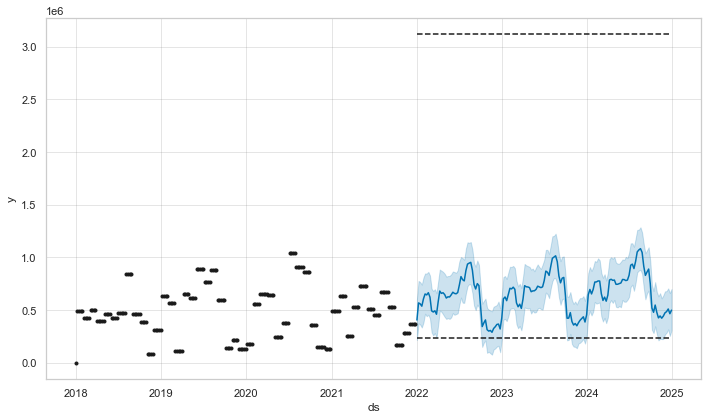

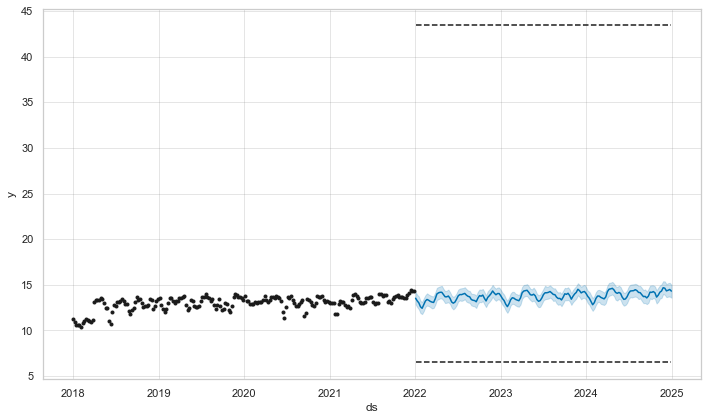

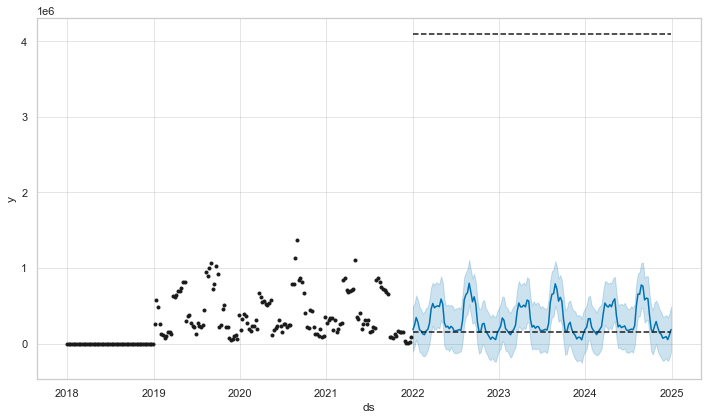

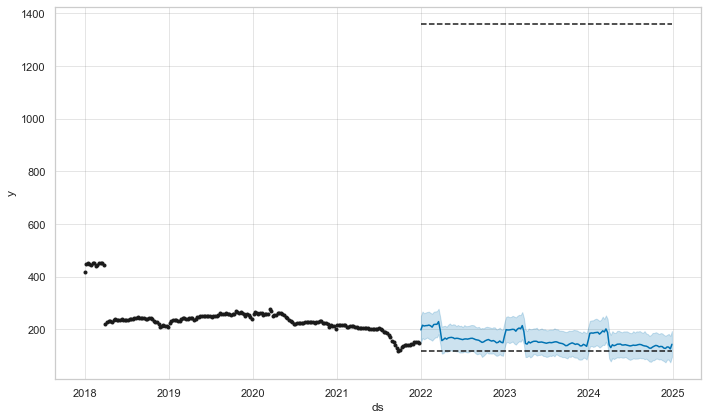

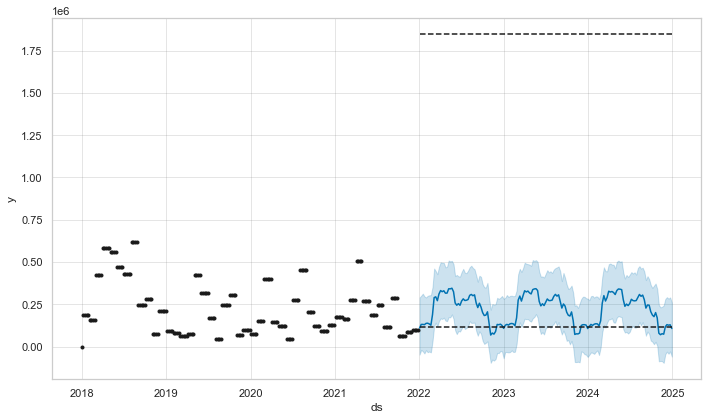

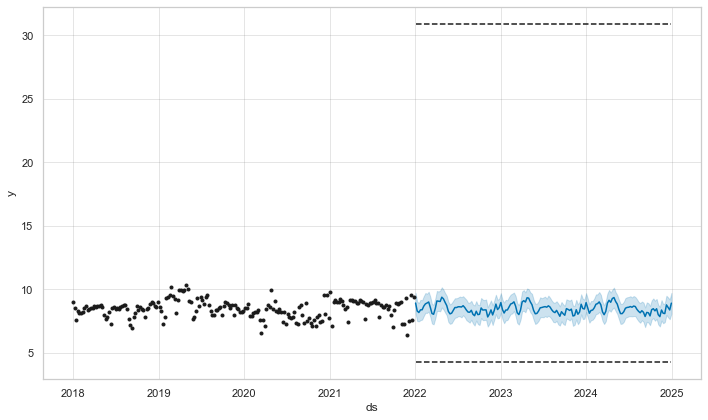

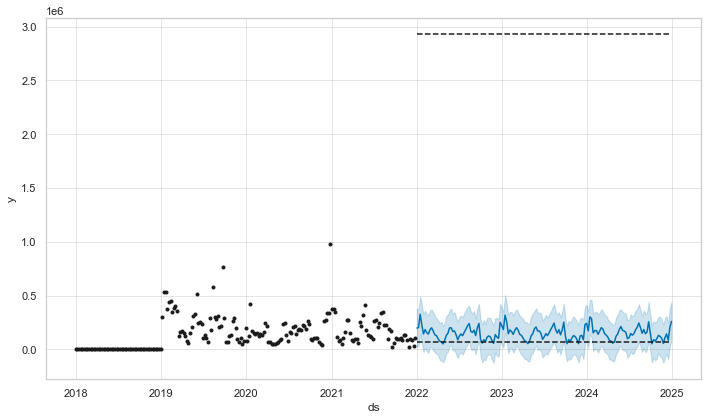

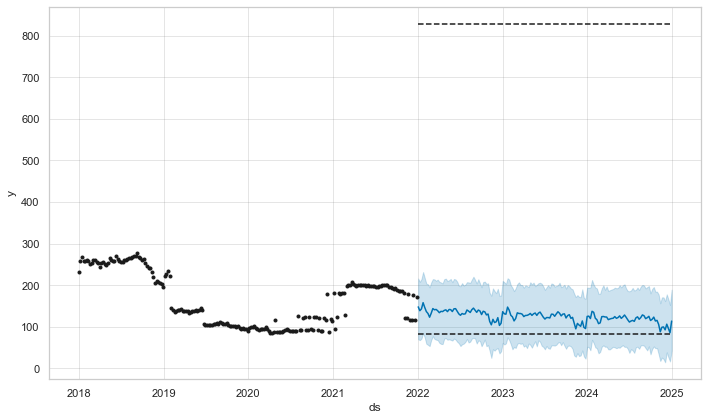

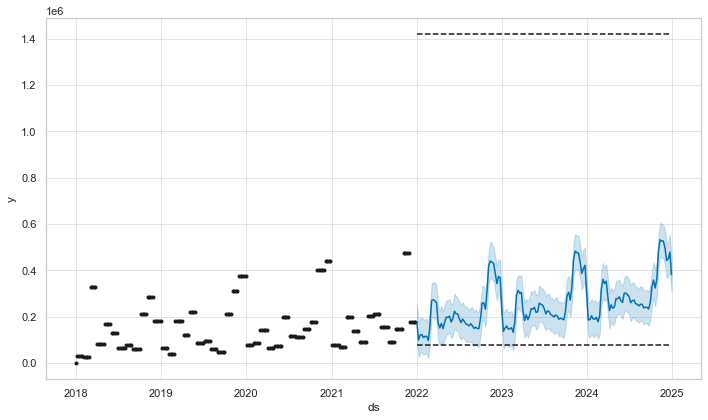

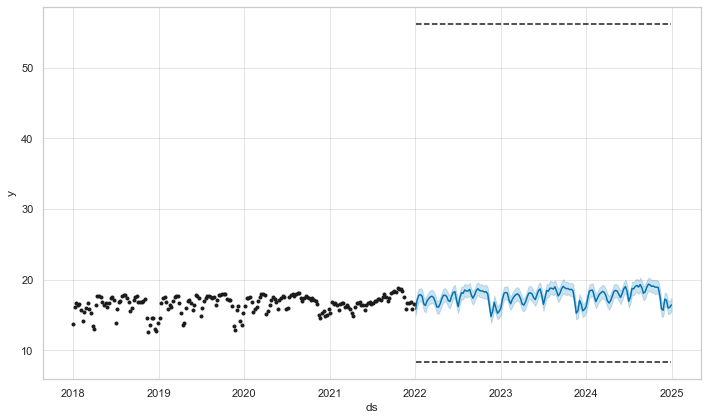

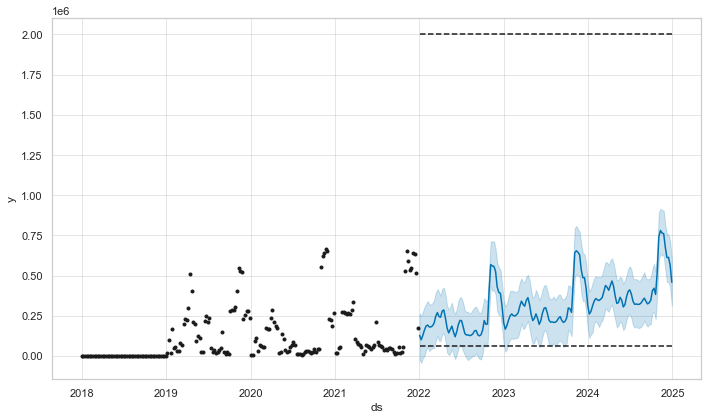

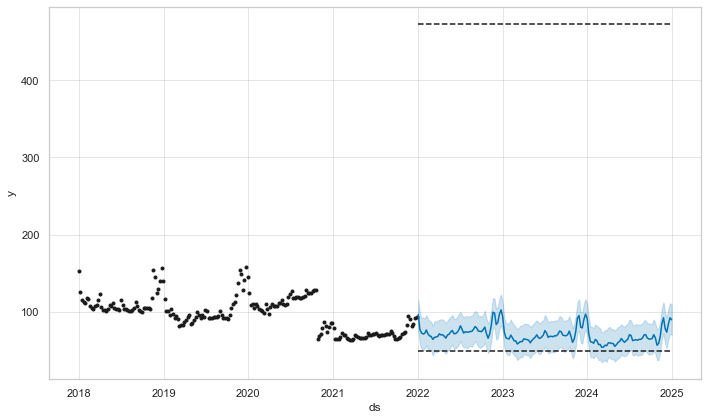

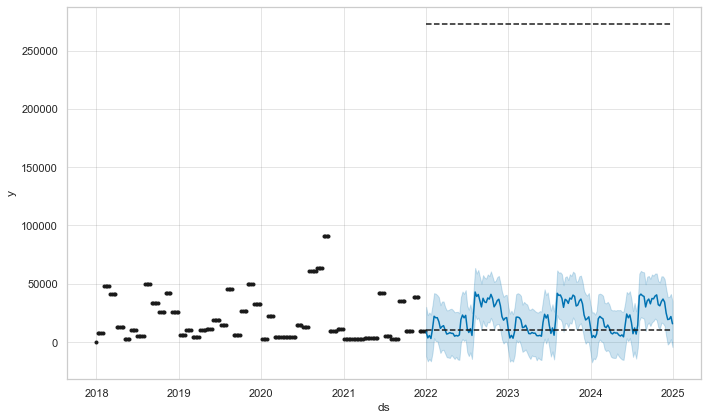

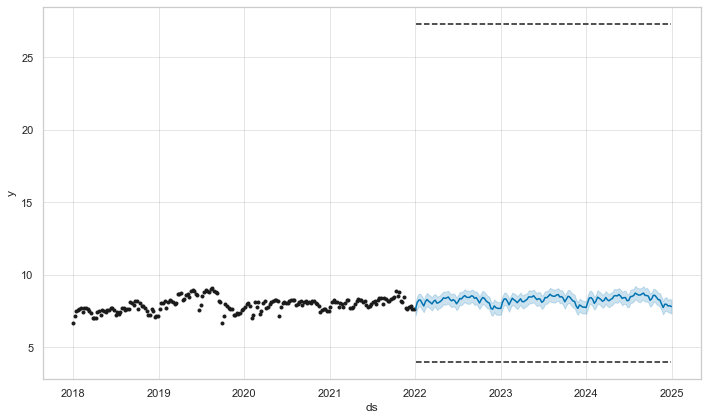

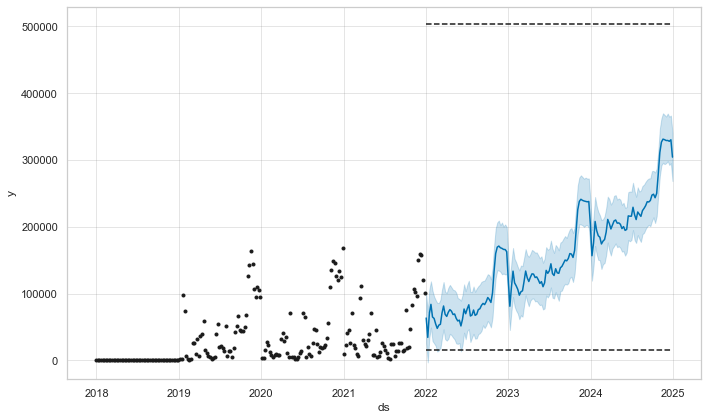

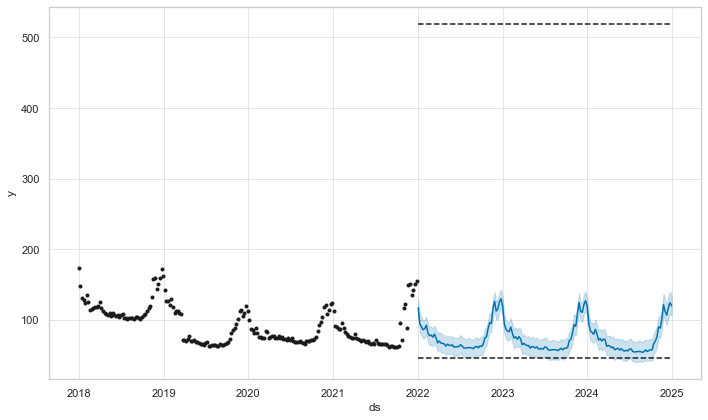

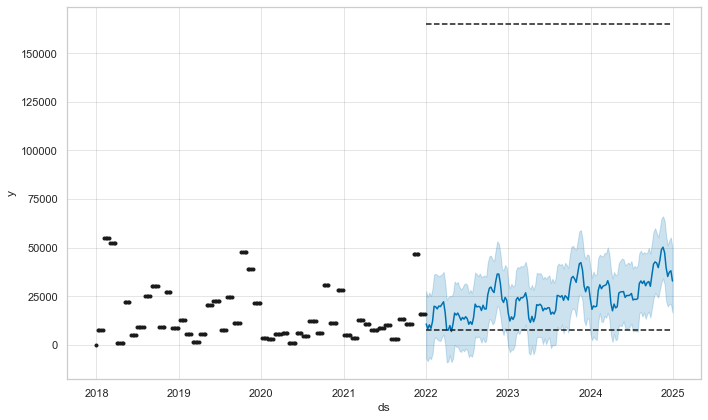

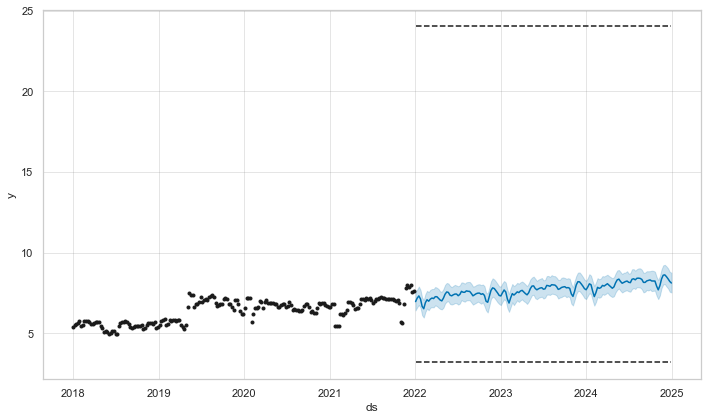

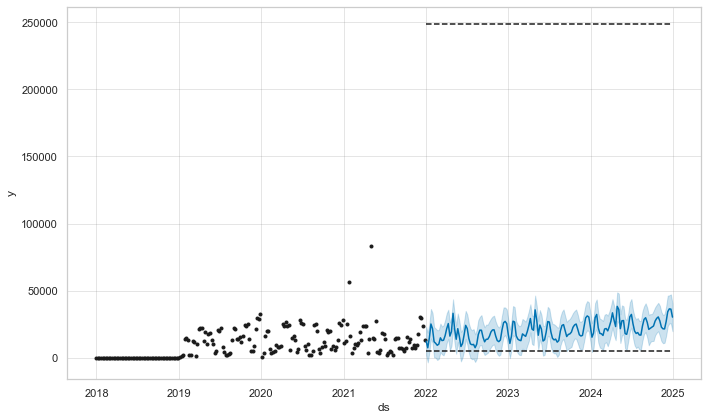

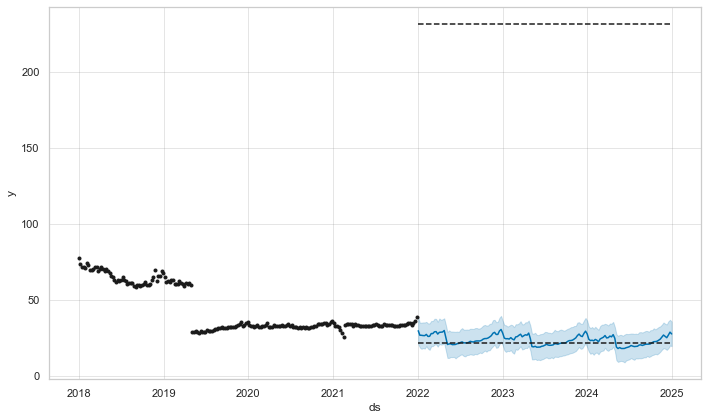

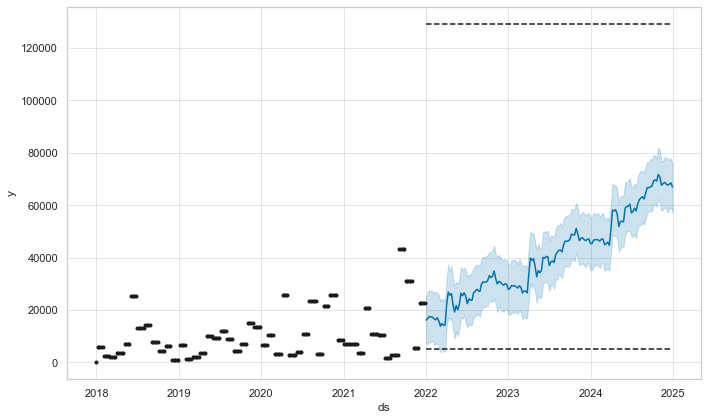

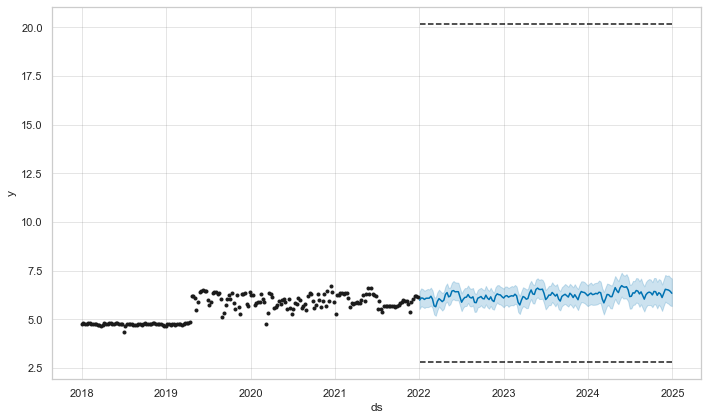

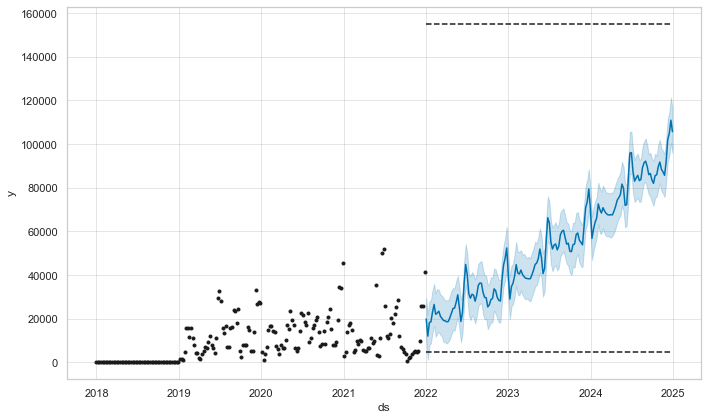

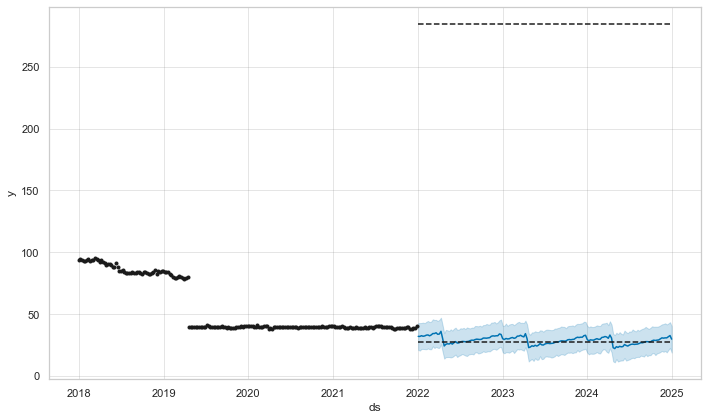

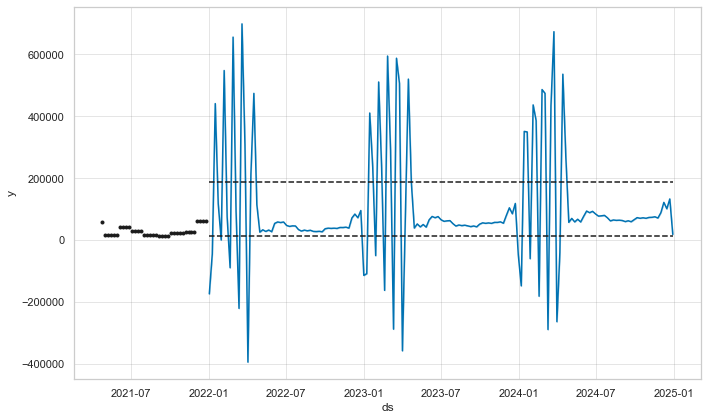

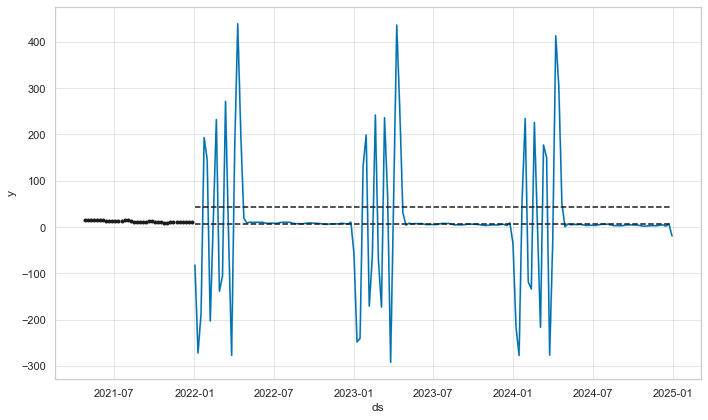

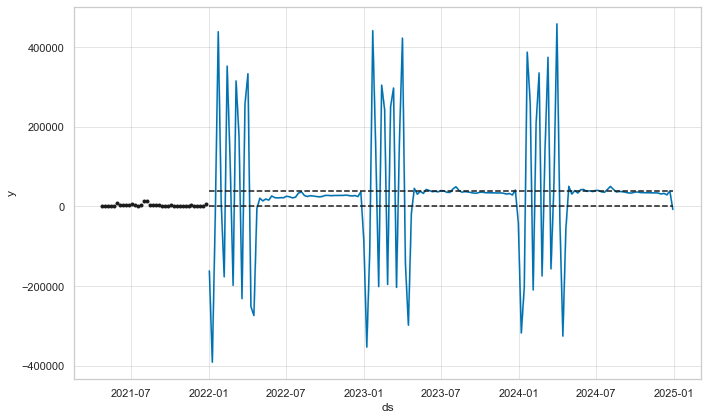

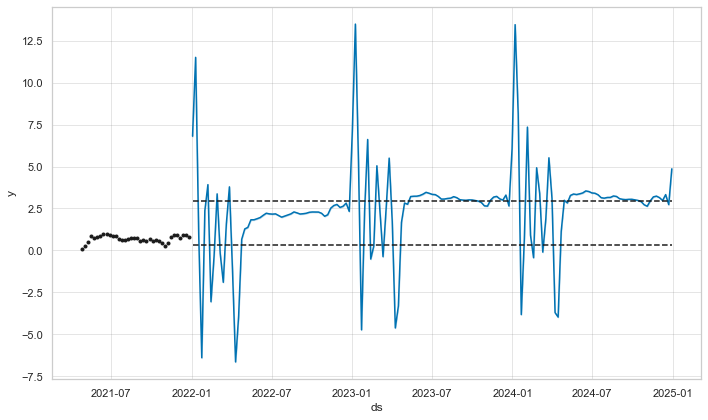

In [16]:
features_name = ['A&P', 'Price per volume', 'Promo Cost', 'Distribution']
feats_futures, df_brands_fcst_res = forecasting_brands(df_bel, brands_name[country], features_name, periods=157, freq='W')

In [17]:
df_brands_fcst_res.fillna(0, inplace=True)
df_brands_fcst_res['Date'] = df_brands_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_brands_fcst_res.round(1).to_excel("results/USA/usa_brands_forecasts_with_regressors.xlsx", index=False)

array([<AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>, <AxesSubplot:xlabel='Date'>,
       <AxesSubplot:xlabel='Date'>], dtype=object)

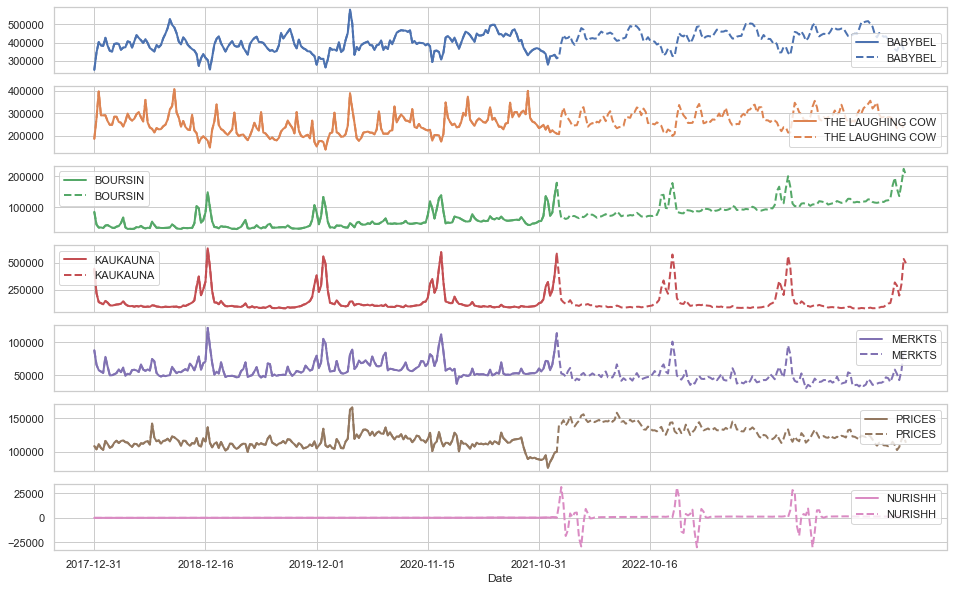

In [18]:
ax = df_brands_fcst_res.set_index("Date").loc['2017-12-31':'2021-12-26'].plot(linewidth=2, subplots=True, figsize=(16, 10))
df_brands_fcst_res.set_index("Date").plot(linewidth=2, linestyle='--', subplots=True, figsize=(16, 10), ax=ax)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

array([<AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>,
       <AxesSubplot:xlabel='ds'>, <AxesSubplot:xlabel='ds'>], dtype=object)

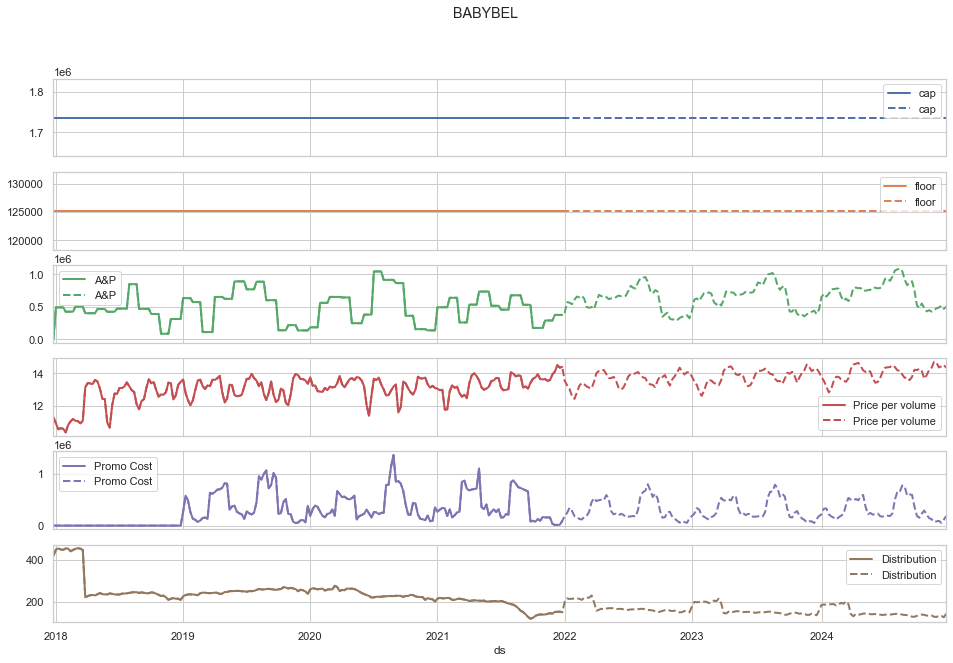

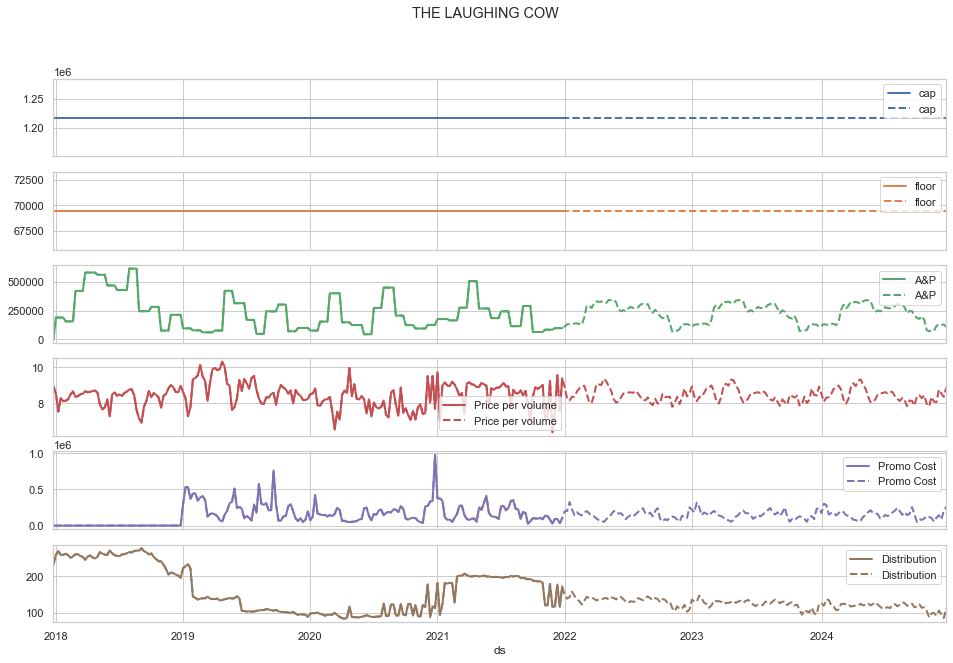

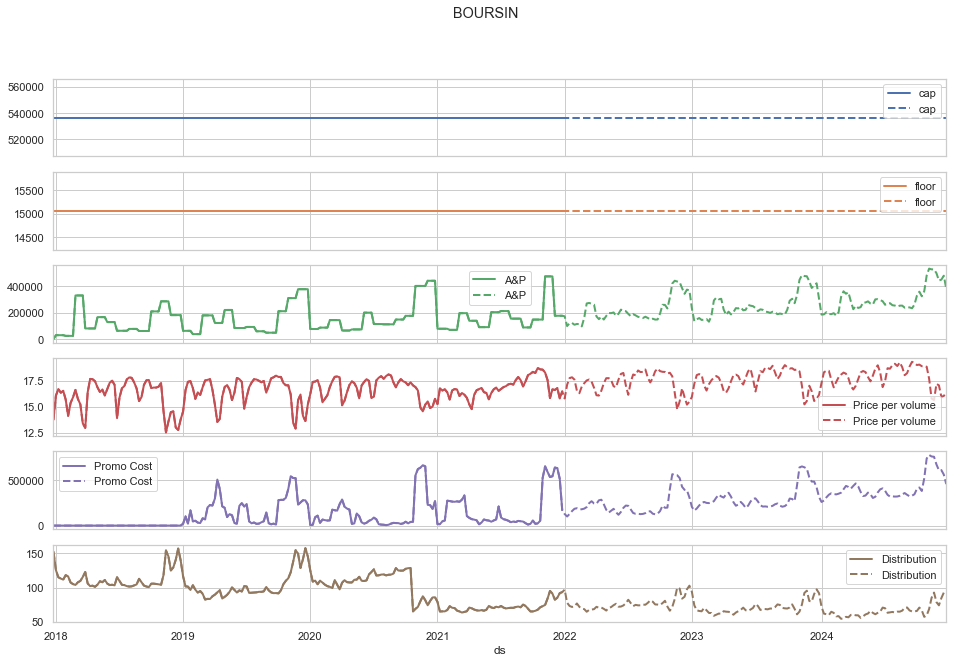

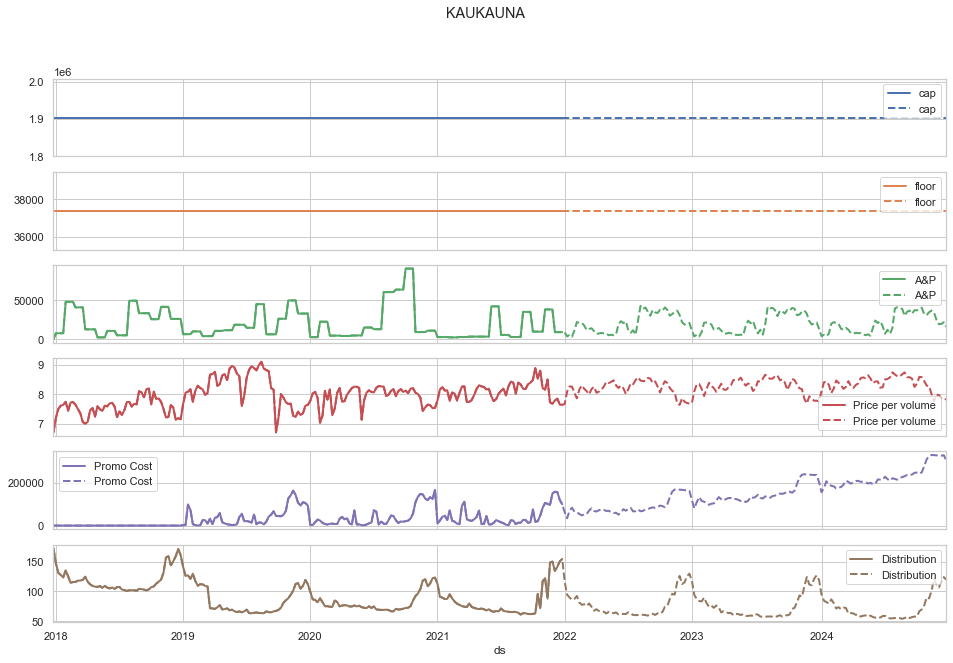

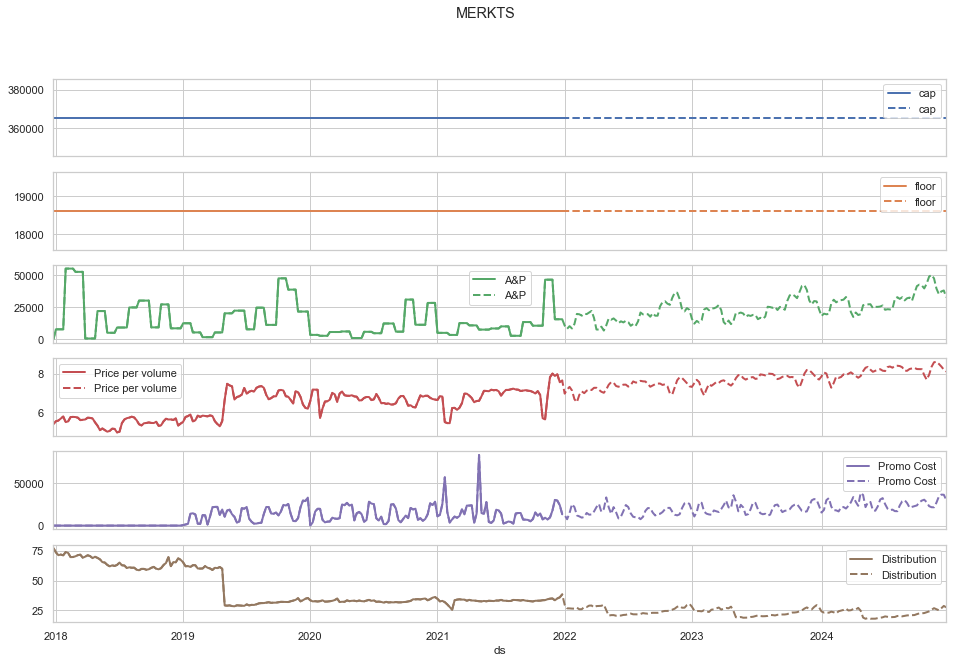

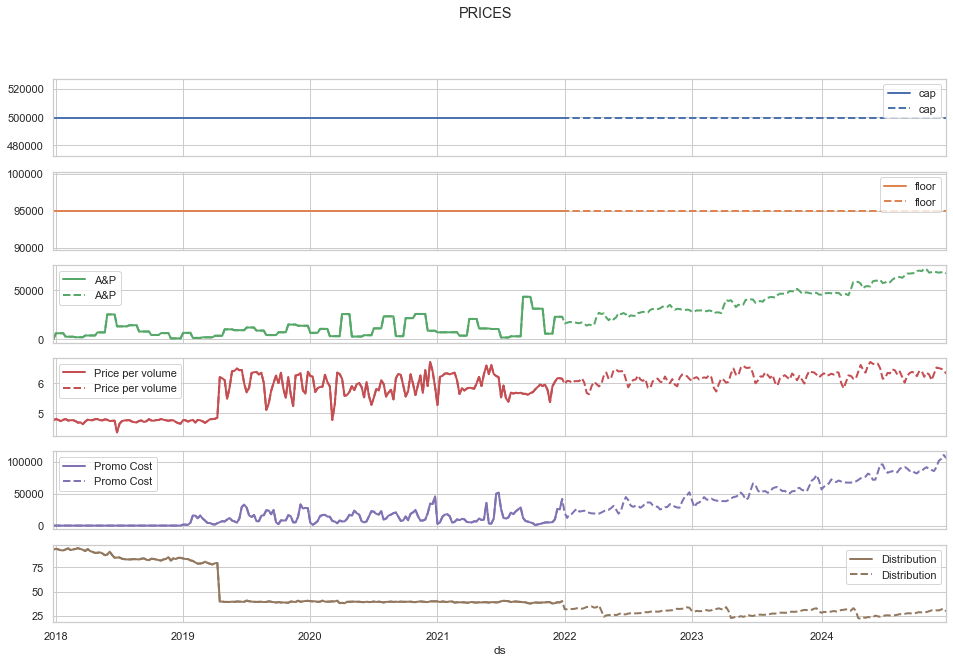

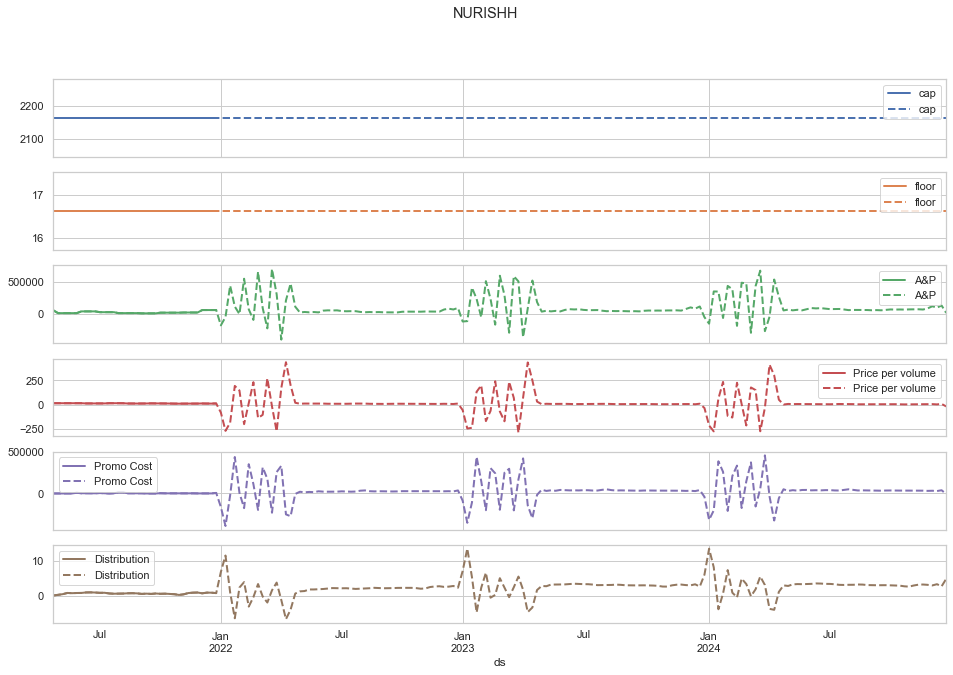

In [19]:
for brand in feats_futures:
    ax = feats_futures[brand].set_index('ds').loc['2017-12-31':'2021-12-26'].plot(subplots=True, figsize=(16, 10), title=brand, linewidth=2);
    feats_futures[brand].set_index('ds').plot(
        subplots=True, figsize=(16, 10), title=brand,
        linestyle='--', linewidth=2, ax=ax);

## Forecasting Markets

In [20]:
features_markets = list(df.Category.unique()) + ['TOTAL CHEESE']
df_markets = get_df_markets(df)
df_markets.head()

,Date,CLASSIC SPREADS,CREAM CHEESE,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,PLANT BASED,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS,TOTAL CHEESE
0,2017-12-31,556099.935784,1.033235e+07,1.502459e+06,1.672481e+07,2.591275e+07,899559.934396,801052.378777,1.430267e+06,154547.998941,807221.657009,450073.275428,182981.446283,2.945739e+06,1.208037e+07,4.945789e+06,2.172508e+06,8.189857e+07
1,2018-01-07,390664.450959,7.519594e+06,8.878940e+05,1.453252e+07,2.628333e+07,619468.304908,844736.884993,1.146266e+06,144260.559694,450767.240308,458259.684991,196951.775652,2.100265e+06,1.397689e+07,6.439323e+06,3.459148e+06,7.945034e+07
2,2018-01-14,358948.174883,6.665960e+06,4.492479e+05,1.322535e+07,2.533961e+07,531928.485964,879634.905349,1.034399e+06,143662.079434,325780.725853,502895.706163,205332.246870,2.013697e+06,1.480020e+07,7.008360e+06,3.769736e+06,7.725474e+07
3,2018-01-21,344453.590714,6.555467e+06,4.660944e+05,1.268997e+07,2.471744e+07,521978.033942,864079.716163,1.021411e+06,149351.267530,312998.041373,451407.992958,196801.380501,1.984600e+06,1.403472e+07,6.541865e+06,3.674175e+06,7.452682e+07
4,2018-01-28,337169.132159,6.568254e+06,4.606846e+05,1.177196e+07,2.334294e+07,505710.471442,844956.077292,1.034156e+06,137656.835024,314342.702673,443363.429657,191555.917983,1.896823e+06,1.291319e+07,6.394770e+06,3.487291e+06,7.064482e+07


In [21]:
features_markets

['CLASSIC SPREADS',
 'CREAM CHEESE',
 'ENTERTAINING TRAYS',
 'EVERYDAY BLOCKS',
 'EVERYDAY SHREDDED & GRATED',
 'GOURMET BLOCK / WEDGE / ROUND',
 'GOURMET CRUMBLED',
 'GOURMET FRESH ITALIAN',
 'GOURMET SHREDDED / GRATED',
 'GOURMET SPREADS',
 'PIMENTO',
 'RICOTTA AND FARMERS',
 'SLICES',
 'SNACK',
 'SNACKING COMBOS',
 'PLANT BASED',
 'TOTAL CHEESE']

Features:   0%|          | 0/17 [00:00<?, ?it/s]

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

Initial log joint probability = -20.6196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       516.483    6.5136e-05       72.8176   1.125e-06       0.001      115  LS failed, Hessian reset 
      99       516.496   5.59778e-06       84.2882      0.3759           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       516.914     0.0016162       83.0562   2.009e-05       0.001      268  LS failed, Hessian reset 
     199       517.169   5.04544e-08       54.3618     0.08649     0.08649      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       517.648    0.00327701       72.9066   6.274e-05       0.001      547  LS failed, Hessian reset 
     299       517.746   0.000584214       81.0164           1           1      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -21.418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.888     0.0116823       83.6152      0.7043      0.7043      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       478.937    0.00361088       81.2407    4.31e-05       0.001      231  LS failed, Hessian reset 
     199       479.093   1.53818e-05       81.3598      0.1521           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       479.116   0.000474035       107.844   5.599e-06       0.001      404  LS failed, Hessian reset 
     299       479.133    1.3571e-07       91.8958     0.02645      0.9605      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     344       479.134    9.9591e-10       96.3895     0.01441     0.01441      551   
Optimization terminate

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -33.1137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       551.277    0.00034727       73.4871      0.8463      0.8463      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       562.782   0.000176005       69.7812      0.8557      0.8557      239   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       562.814   0.000139491       78.8599   1.349e-06       0.001      315  LS failed, Hessian reset 
     288       562.819   2.46011e-07       86.8494   3.045e-09       0.001      421  LS failed, Hessian reset 
     295       562.819   8.45251e-09       81.0366     0.01944      0.6646      431   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -21.3536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       416.905   0.000494313       43.5492   8.963e-06       0.001       96  LS failed, Hessian reset 
      84       417.027   0.000508147       60.1624   8.287e-06       0.001      208  LS failed, Hessian reset 
      99       417.043   0.000576838       72.3392          10           1      234   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       417.308    0.00241218       76.7766   3.064e-05       0.001      377  LS failed, Hessian reset 
     199       417.562    8.9807e-06       42.4948           1           1      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       417.569   1.83436e-05       50.5569   2.371e-07       0.001      560  LS failed, Hessian reset 
     287       417.569   3.20349e-06       84.7962   6.134e-08   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -8.52619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        423.15   3.62275e-05       88.6902      0.3376      0.3376      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        423.19   0.000357312       90.5965   3.923e-06       0.001      192  LS failed, Hessian reset 
     199       423.371    0.00017256       83.9446      0.1209           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       423.417   0.000563669        57.631   8.614e-06       0.001      358  LS failed, Hessian reset 
     299       423.941    0.00163188       78.5063       0.186      0.6722      478   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     397       424.042   1.37511e-05       92.4734   1.937e-07       0.001      645  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -21.955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       572.683     0.0259919       91.5363           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       577.699   0.000113383       90.9217   1.154e-06       0.001      280  LS failed, Hessian reset 
     199       577.704   2.19289e-05       77.7905       0.343           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280        577.73    0.00015231       90.6568    1.39e-06       0.001      428  LS failed, Hessian reset 
     299       577.745   2.43802e-05       90.0315      0.2604           1      453   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     347       577.751   3.28262e-08       56.3569      0.3652           1      522   
Optimization terminate

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.78082
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       459.207    0.00060839       88.7265   6.601e-06       0.001      129  LS failed, Hessian reset 
      99       459.258   4.69233e-07       73.6218      0.4594      0.4594      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       459.258    9.1248e-09       80.7757      0.1611      0.1611      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -13.1774
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.235     0.0193879       58.7676           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       394.698   4.10375e-05       59.1971      0.8501      0.8501      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       394.707   0.000128375       62.6336   1.161e-06       0.001      311  LS failed, Hessian reset 
     257       394.711   2.63358e-07       49.4298   3.485e-09       0.001      424  LS failed, Hessian reset 
     270       394.711   1.32788e-08       76.9376      0.1716           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -5.38034
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        486.07   5.41136e-05       69.3201      0.3828           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137        486.19     0.0010556       76.4129   1.293e-05       0.001      215  LS failed, Hessian reset 
     198       486.238   1.06046e-07       76.5575   1.203e-09       0.001      332  LS failed, Hessian reset 
     199       486.238   3.11092e-08       59.3544      0.8904      0.8904      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       486.238   1.20065e-08       73.5413     0.04524           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -43.1041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       586.849   0.000106099       80.0171      0.1947           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       587.761   5.49745e-05       86.9528      0.4243           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         588.5   1.36539e-07       78.2373           1           1      393   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     311         588.5   2.62054e-08       74.8826           1           1      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.80413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.338   5.30386e-05       53.6522           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       481.848    0.00733391       107.814   9.406e-05       0.001      207  LS failed, Hessian reset 
     134       482.221   0.000295163       43.2034    5.85e-06       0.001      280  LS failed, Hessian reset 
     138       482.226   8.18613e-05       38.5402   2.892e-06       0.001      316  LS failed, Hessian reset 
     199       482.403   1.47062e-06       52.1414      0.7833     0.07833      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       482.404   5.69423e-06       42.1347   8.804e-08       0.001      498  LS failed, Hessian reset 
     234       482.404   1.61235e-08       29.2345    0.008893   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -28.4529
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.348     0.0109503       105.376       0.331       0.331      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       475.355   0.000287337       55.5427       4.328     0.04328      278   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       475.363   0.000146978       51.6038   2.321e-06       0.001      334  LS failed, Hessian reset 
     232       475.369   1.95249e-05       66.8918   2.484e-07       0.001      421  LS failed, Hessian reset 
     247       475.369   1.15416e-06       52.5199    2.05e-08       0.001      472  LS failed, Hessian reset 
     298       475.373   7.95703e-05       81.5803   1.306e-06       0.001      588  LS failed, Hessian reset 
     299       475.374   3.14881e-05       24.9392           1   

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -4.13932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       472.163    8.1872e-05       60.4988      0.1583      0.1583      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       472.439   0.000286882       65.6782   4.721e-06       0.001      281  LS failed, Hessian reset 
     198       472.477   9.72133e-09       75.7144      0.4622      0.4622      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -5.44707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       540.262    0.00103809        76.725   1.008e-05       0.001      171  LS failed, Hessian reset 
      99       540.286   0.000608496       72.2347           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       540.346   5.74679e-06        77.847    8.15e-08       0.001      282  LS failed, Hessian reset 
     178       540.347    4.4353e-09       81.2959      0.1708      0.1708      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -22.483
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       378.791     0.0283837       99.6762           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         391.3   0.000482898       91.2843      0.3645           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       391.368   0.000160929       98.3881   1.414e-06       0.001      342  LS failed, Hessian reset 
     288       391.375   1.17391e-06       79.1146   1.491e-08       0.001      444  LS failed, Hessian reset 
     299       391.375   4.78206e-08       67.8929           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       391.375   1.43954e-08       73.1089      0.1718           1      473   
Optimization terminate

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -3.43672
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.854    0.00846825        94.563       0.785       0.785      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       492.994   1.57761e-05       74.0634      0.6136      0.6136      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208        493.03   0.000356757         93.38   3.648e-06       0.001      298  LS failed, Hessian reset 
     258       493.047    2.4072e-08       72.6937           1           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/generic.py:5516: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentatio

Initial log joint probability = -9.63039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       456.027    0.00277809        57.103     3.5e-05       0.001      171  LS failed, Hessian reset 
      99       456.175    0.00112632        65.531       0.362      0.9987      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       456.981   0.000294033       60.2333   5.049e-06       0.001      358  LS failed, Hessian reset 
     199           457   0.000139257       72.1206           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        457.54   0.000829289       62.9332      0.6319           1      497   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       458.327   0.000222806       69.9159    3.42e-06       0.001      695  LS failed, Hessian rese

/Users/ahmed/miniconda/envs/pt/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


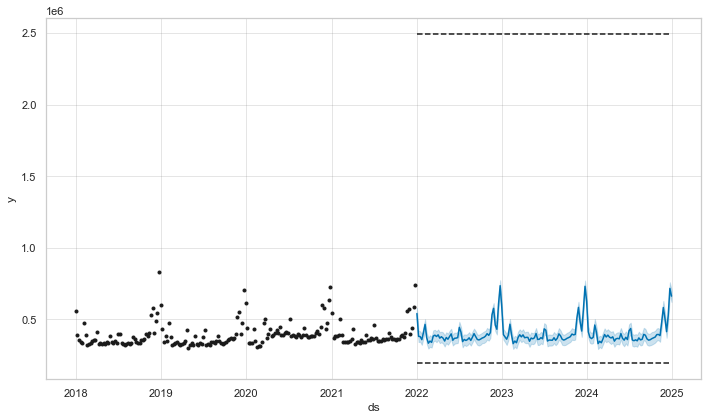

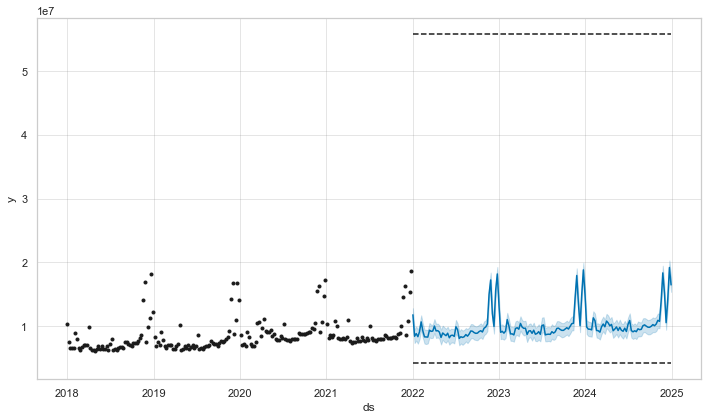

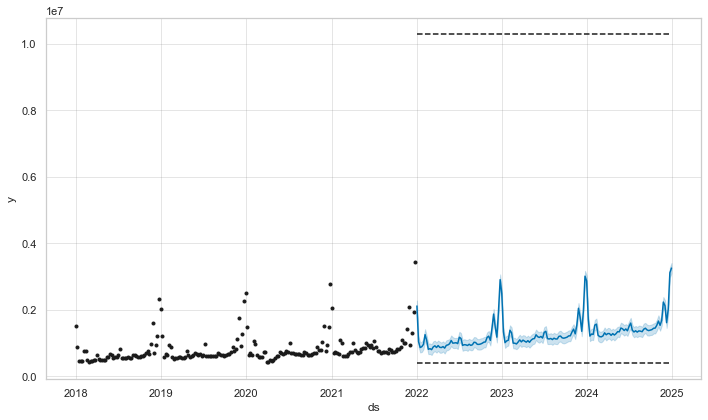

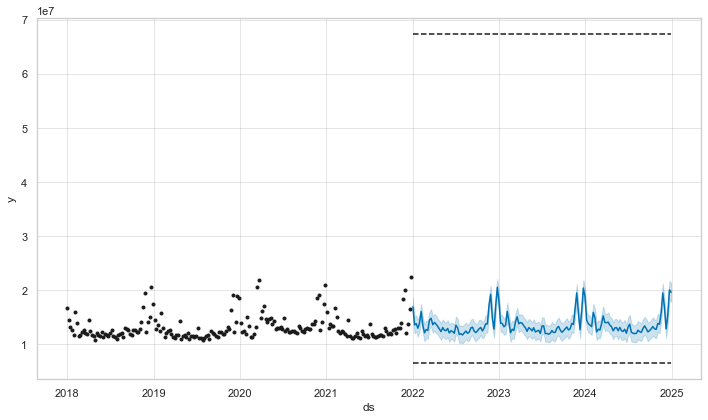

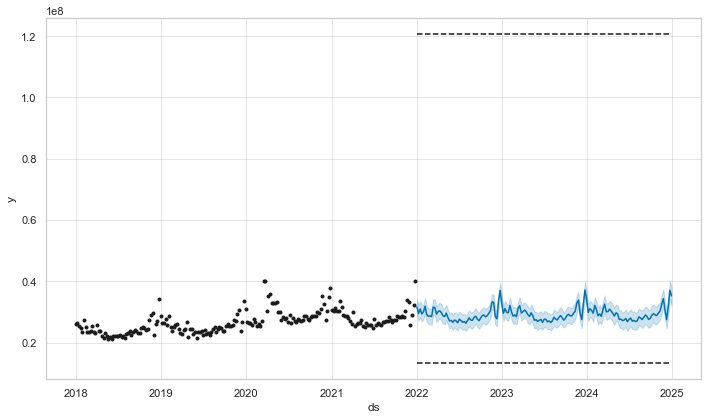

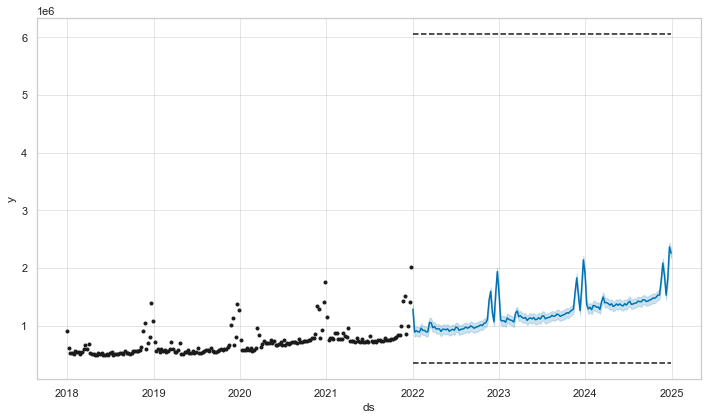

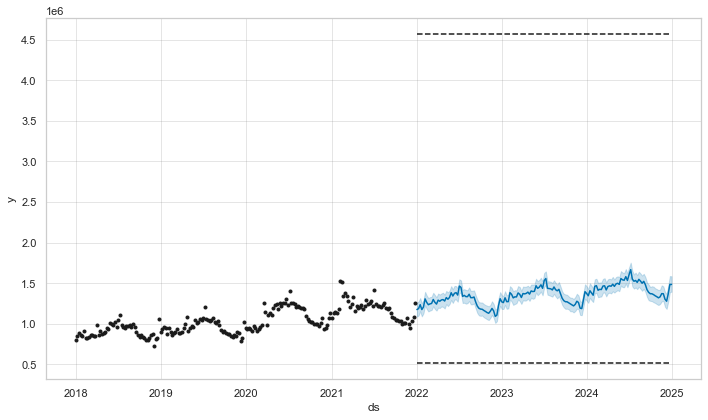

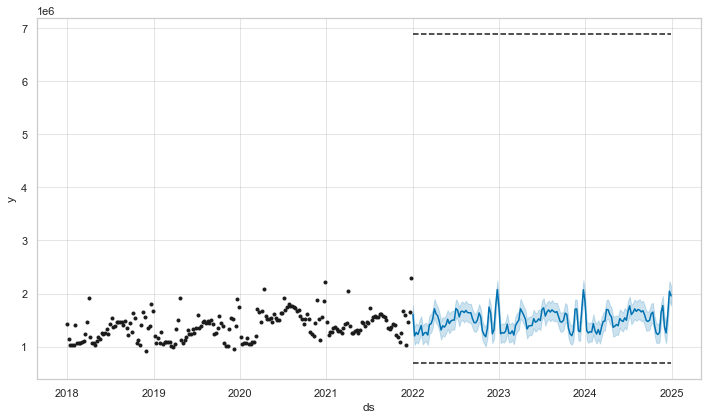

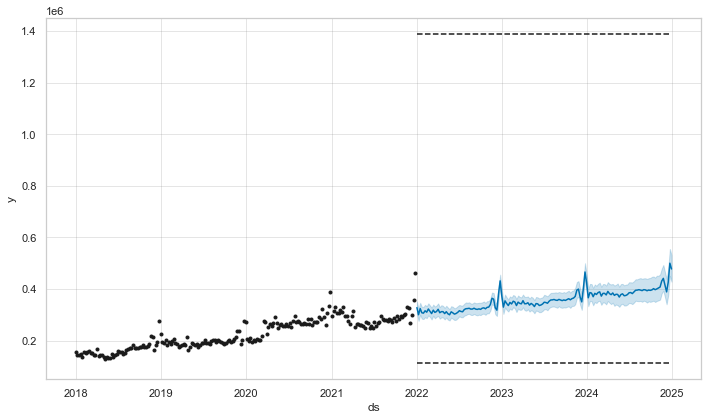

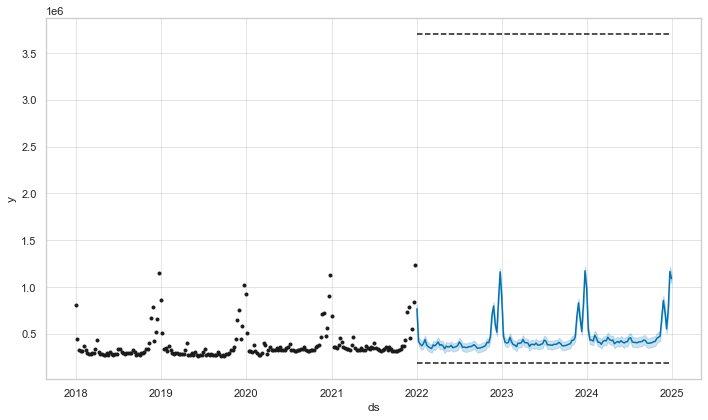

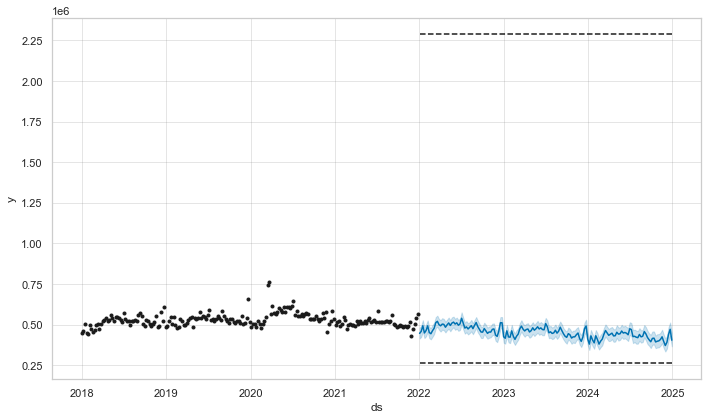

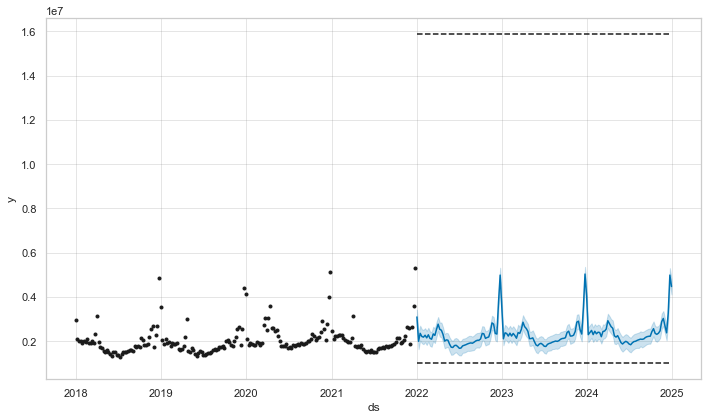

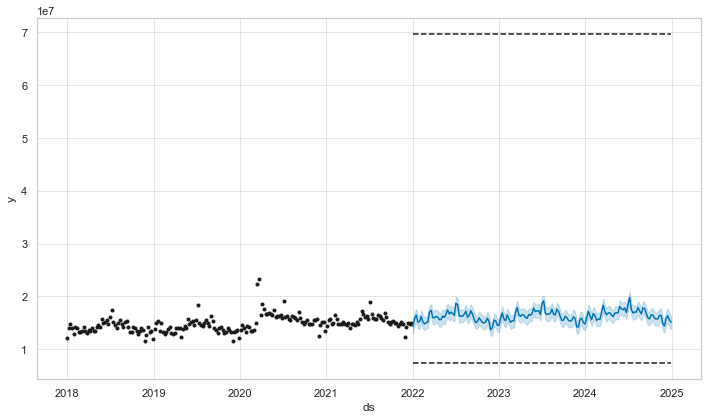

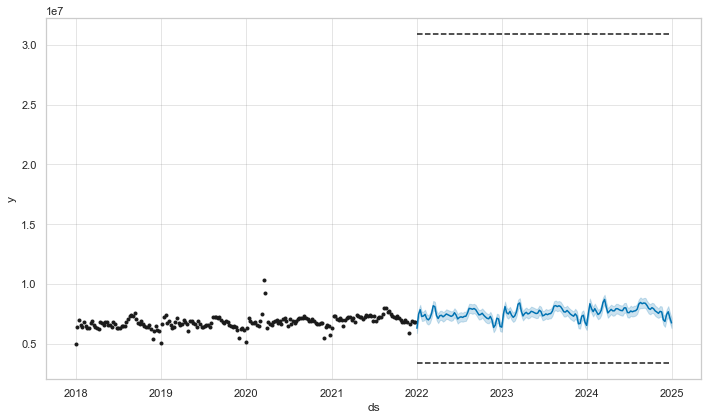

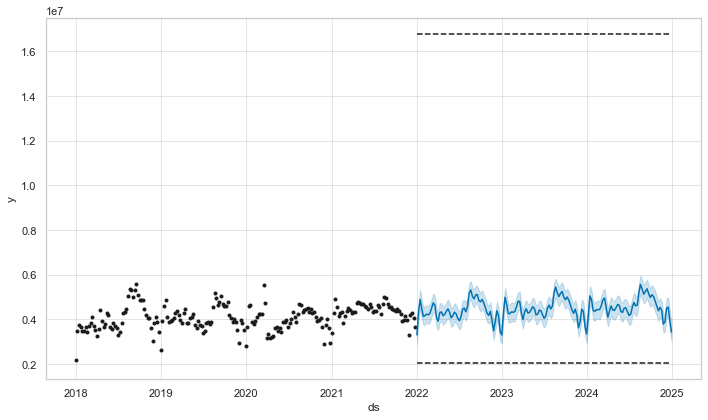

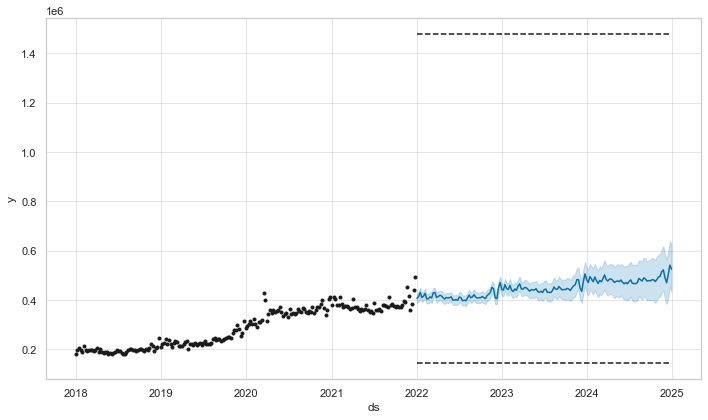

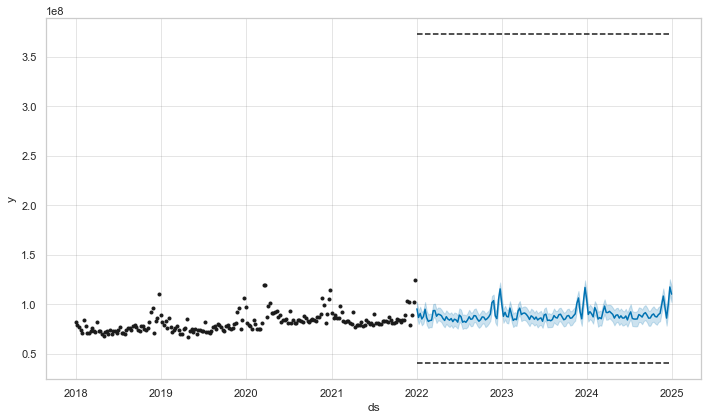

In [22]:
df_markets_fcst_res = forecasting_markets(df_markets, features_markets, periods=157, freq='W')

In [23]:
df_markets_fcst_res.tail()

,Date,CLASSIC SPREADS,CREAM CHEESE,ENTERTAINING TRAYS,EVERYDAY BLOCKS,EVERYDAY SHREDDED & GRATED,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,PIMENTO,RICOTTA AND FARMERS,SLICES,SNACK,SNACKING COMBOS,PLANT BASED,TOTAL CHEESE
361,2024-12-01,506397.333766,1.519785e+07,2.122261e+06,1.687773e+07,3.067466e+07,1.870059e+06,1.301801e+06,1.373074e+06,414676.020986,7.367941e+05,371665.260218,2.681912e+06,1.439668e+07,6.867231e+06,3.890903e+06,491237.461021,9.703500e+07
362,2024-12-08,413647.186835,1.056272e+07,1.611919e+06,1.283889e+07,2.750147e+07,1.529257e+06,1.276845e+06,1.256162e+06,388689.328722,5.531199e+05,391591.021332,2.371018e+06,1.582035e+07,7.449945e+06,4.502864e+06,470592.352079,8.617600e+07
363,2024-12-15,528515.964742,1.424246e+07,2.017617e+06,1.532967e+07,3.152989e+07,1.818589e+06,1.367324e+06,1.607244e+06,426448.257832,7.602027e+05,440230.160562,3.262515e+06,1.633962e+07,7.680419e+06,4.547871e+06,503562.042808,9.961981e+07
364,2024-12-22,715995.326888,1.920769e+07,3.113747e+06,2.006978e+07,3.706013e+07,2.363986e+06,1.483431e+06,2.043882e+06,499898.300931,1.166489e+06,471610.882957,4.981537e+06,1.553703e+07,7.172614e+06,3.926609e+06,541905.076741,1.175743e+08
365,2024-12-29,661953.317692,1.648699e+07,3.252846e+06,1.961573e+07,3.524565e+07,2.256441e+06,1.483262e+06,1.955496e+06,477563.940984,1.090894e+06,404474.076375,4.467345e+06,1.509974e+07,6.746763e+06,3.439219e+06,525857.774756,1.103597e+08


In [24]:
df_markets_fcst_res['Date'] = df_markets_fcst_res.Date.apply(lambda x: x.strftime('%Y-%m-%d'))
df_markets_fcst_res.round(1).to_excel("./results/USA/usa_markets_forecasts_ok.xlsx", index=False)

In [76]:
df_markets_results = pd.merge(df_gourmet_fcst_res, df_markets_fcst_res, on='Date')
df_markets_results.tail()

,Date,GOURMET BLOCK / WEDGE / ROUND,GOURMET CRUMBLED,GOURMET FRESH ITALIAN,GOURMET SHREDDED / GRATED,GOURMET SPREADS,CLASSIC SPREADS,CREAM CHEESE BLOCKS,CREAM CHEESE TUBS,ENTERTAINING TRAYS,...,EVERYDAY SHREDDED & GRATED,GOURMET,PIMENTO,RICOTTA AND FARMERS,SINGLE SERVE,SLICES,SNACK,SNACKING COMBOS,PLANT BASED,TOTAL CHEESE
361,2024-12-01,1.427448e+06,797798.310339,1.276152e+06,332751.871991,640425.132686,457319.756492,9.335321e+06,3.959608e+06,1.645872e+06,...,2.821070e+07,4.607664e+06,336115.187332,2.122262e+06,609.315736,1.422315e+07,7.314728e+06,4.581783e+06,479116.276372,9.314850e+07
362,2024-12-08,1.411002e+06,793358.807713,1.263219e+06,336799.541064,669862.273462,466362.910776,8.745482e+06,3.966325e+06,1.732246e+06,...,2.778234e+07,4.608752e+06,351566.226454,2.474562e+06,604.470550,1.419426e+07,7.373626e+06,4.727702e+06,474500.465954,9.188077e+07
363,2024-12-15,1.567934e+06,844270.306676,1.478951e+06,361769.869095,822161.719547,539899.423552,9.612026e+06,4.139455e+06,2.167063e+06,...,2.971123e+07,5.210300e+06,379563.625557,3.285347e+06,440.605670,1.436223e+07,7.360306e+06,4.614616e+06,487486.689125,9.793698e+07
364,2024-12-22,1.770080e+06,919427.255980,1.726741e+06,388134.488146,979540.584813,616995.884305,1.091916e+07,4.324110e+06,2.663926e+06,...,3.226533e+07,5.918810e+06,391749.670678,3.917995e+06,96.886920,1.462187e+07,7.283961e+06,4.326532e+06,507043.058425,1.059140e+08
365,2024-12-29,1.791477e+06,961966.501930,1.731182e+06,391959.910474,970586.778792,606311.259774,1.061566e+07,4.324926e+06,2.744565e+06,...,3.280496e+07,5.981270e+06,371538.883583,3.784911e+06,-102.376548,1.482039e+07,7.307407e+06,4.214736e+06,516293.924305,1.068928e+08


In [78]:
df_markets_results = df_markets_results[['Date', 'GOURMET BLOCK / WEDGE / ROUND', 'GOURMET CRUMBLED',
       'GOURMET FRESH ITALIAN', 'GOURMET SHREDDED / GRATED', 'GOURMET SPREADS', 'GOURMET',
       'CLASSIC SPREADS', 'CREAM CHEESE BLOCKS', 'CREAM CHEESE TUBS',
       'ENTERTAINING TRAYS', 'EVERYDAY BLOCKS', 'EVERYDAY SHREDDED & GRATED',
       'PIMENTO', 'RICOTTA AND FARMERS', 'SINGLE SERVE', 'SLICES',
       'SNACK', 'SNACKING COMBOS', 'PLANT BASED', 'TOTAL CHEESE']]

In [79]:
df_markets_results['Date'] = df_markets_results.Date.apply(lambda x: x.strftime('%Y-%m-%d'))

In [80]:
df_markets_results.to_excel("./results/usa_markets_forecasts.xlsx", index=False)

## Growth Drivers Past

- Distribution per : mean
- Price per volume per category : mean
- Competition price per category : mean
- Competition sales per category : sum


In [25]:
def growth_drivers(df_bel, df_markets, df_competition_brands, brands_name, brands_markets, controllable_features=False):
    dict_res = {'xgb_feature_importance': {}, 'permutation_importance': {}}
    competition_feats_cat = ['Competition price', 'Competition sales']
    compet_feats = []
    for brand in tqdm(brands_name, ascii=True, desc='Brands'):
        # Competition features
        feats_cat = [feat+'_'+cat for cat in brands_markets[brand] 
                     for feat in competition_feats_cat]
        
        df_tmp = df_bel[df_bel.Brand == brand]
        
        if not controllable_features:
            df_tmp = pd.merge(df_tmp, df_competition_brands[['Date'] + feats_cat], on='Date')
            df_tmp = pd.merge(df_tmp, df_markets[['Date'] + brands_markets[brand]], on='Date')
        
        if len(df_tmp) == 0:
            continue
        
        # Add competition features if df_tmp is not empty (eg: NURISHH for 2019, 2020, etc...) 
        compet_feats += feats_cat
        
        for key in dict_res:
            dict_res[key][brand] = {}
        
        df_tmp_X = df_tmp.drop(['Date', 'Brand', 'Sales in volume'], axis=1)
        X = df_tmp_X.values
        y = df_tmp['Sales in volume']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
        xgb_model = XGBRegressor()
        xgb_model.fit(X_train, y_train)

        # XGB Feature importance
        feature_importances = xgb_model.feature_importances_
        sorted_idx_feat_imp = feature_importances.argsort()
        perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=25)
        sorted_idx_perm_imp = perm_importance.importances_mean.argsort()
        for idx_fi, idx_pi in zip(sorted_idx_feat_imp, sorted_idx_perm_imp):
            dict_res['xgb_feature_importance'][brand][df_tmp_X.columns[idx_fi]] = feature_importances[idx_fi] * 100
            dict_res['permutation_importance'][brand][df_tmp_X.columns[idx_pi]] = perm_importance['importances_mean'][idx_pi] * 100

    # Set compet feats, cause many brands are in the same markets. 
    # np.delete, in order to remove 'Sales in volume', and [2:], to remove Date and Brand
    if controllable_features:
        ordered_drivers = list(df_bel.columns[2:-1])
    else:
        bel_markets = list(set([elem for brand in dict_res['xgb_feature_importance'] for elem in brands_markets[brand]]))
        ordered_drivers = bel_markets + list(set(compet_feats)) + list(df_bel.columns[2:-1])
    print(ordered_drivers)
    for dict_imp in dict_res:
        dict_res[dict_imp] = pd.DataFrame(dict_res[dict_imp]).loc[ordered_drivers]
        
    return dict_res

def compute_growth_drivers_past(df, df_bel, brands_name, features, years=[2018, 2019, 2020, 2021], controllable_features=False):
    """
    """

    brands_markets = {brand: df[df.Brand == brand].Category.unique().tolist() for brand in brands_name}
    # Get markets dataframe
    df_markets = get_df_markets(df)
    # Computing competition price and sales for bel brands
    df_competition_brands = get_df_competition_brands(df, brands_name, features)
    df_competition_brands = df_competition_brands.groupby(['Date', 'Category']).agg(
        {'Price per volume': np.mean, 
         'Sales in volume':  np.sum}).unstack().rename(
        columns={'Price per volume': 'Competition price', 'Sales in volume': 'Competition sales'})
    df_competition_brands.columns = ['_'.join(elem) for elem in df_competition_brands.columns]
    df_competition_brands = df_competition_brands.reset_index()
    dict_res = {year:{} for year in years}
    
    for year in tqdm(years, ascii=True, desc='Years'):
        df_bel_year = df_bel[df_bel.Date.astype('datetime64[ns]').dt.year == year]
        df_compet_year = df_competition_brands[df_competition_brands.Date.astype('datetime64[ns]').dt.year == year]
        df_markets_year = df_markets[df_markets.Date.astype('datetime64[ns]').dt.year == year]
        
        dict_res[year] = growth_drivers(df_bel_year, df_markets_year, 
                                        df_compet_year, brands_name, brands_markets, 
                                        controllable_features=controllable_features)
        
    dict_res['all'] = growth_drivers(df_bel, df_markets, df_competition_brands, 
                                     brands_name, brands_markets, 
                                     controllable_features=controllable_features)
    
    return dict_res

In [26]:
df_bel.head()

,Date,Brand,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH,Trends
0,2017-12-31,BABYBEL,11.307482,250446.559440,2.831920e+06,417.403475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19
1,2017-12-31,BOURSIN,13.745852,85626.196096,1.177005e+06,152.674082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,24
2,2017-12-31,KAUKAUNA,6.703015,444672.382865,2.792992e+06,173.183200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40
3,2017-12-31,MERKTS,5.383924,88166.774383,4.746832e+05,77.224967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,2017-12-31,PRICES,4.762444,108331.433158,5.159224e+05,93.366316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,74


In [27]:
bel_features = ['Date', 'Brand', 'A&P', 'Price per volume',
                'Promo Cost', 'Distribution', 'Sales in volume']
dict_res = compute_growth_drivers_past(
    df, df_bel[bel_features], brands_name[country], features, 
    years=[2018, 2019, 2020, 2021], controllable_features=True)

Years:   0%|          | 0/4 [00:00<?, ?it/s]

Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


In [28]:
for year in dict_res:
    pd.DataFrame(dict_res[year]['xgb_feature_importance']).round(1).to_excel("results/USA/growth_drivers_past_{}_controllable_features.xlsx".format(year))

<Figure size 1152x720 with 0 Axes>

<BarContainer object of 12 artists>

Text(0.5, 0, 'Xgboost Feature Importance')

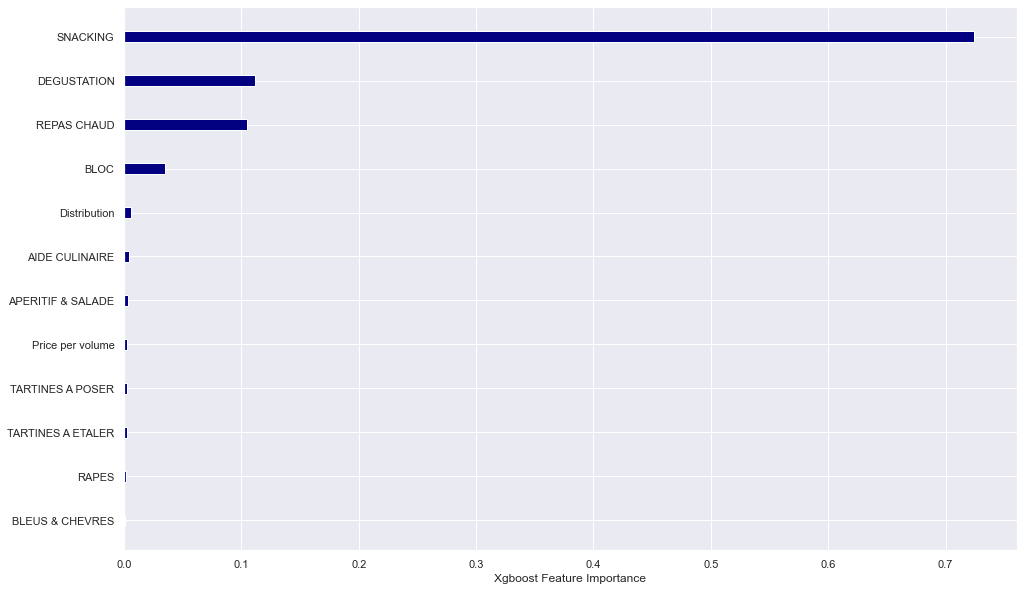

In [233]:
sorted_idx = xgb_model.feature_importances_.argsort()
plt.figure(figsize=(16, 10))
plt.barh(df_gd_past.columns[2:-1][sorted_idx], xgb_model.feature_importances_[sorted_idx], color='navy', height=0.25)
plt.xlabel("Xgboost Feature Importance")

## Growth Drivers Future

In [30]:
df_futures = pd.DataFrame()
for brand in feats_futures:
    feats_futures[brand]['ds'] = feats_futures[brand]['ds'].apply(lambda x: x.strftime("%Y-%m-%d"))
    df_tmp = pd.merge(feats_futures[brand].rename(columns={'ds':'Date'}), 
                     df_brands_fcst_res[['Date', brand]], on='Date').rename(
        columns={brand: 'Sales in volume'})
    df_tmp['Brand'] = brand
    df_futures = pd.concat([df_futures, df_tmp])

In [31]:
dict_res_future = compute_growth_drivers_past(
    df, df_futures[df_futures.Date > df_bel.Date.iloc[-1]][bel_features], brands_name[country], features, 
    years=[2022, 2023, 2024], controllable_features=True)

Years:   0%|          | 0/3 [00:00<?, ?it/s]

Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


In [33]:
for year in dict_res_future:
    pd.DataFrame(dict_res_future[year]['xgb_feature_importance']).round(1).to_excel("results/USA/growth_drivers_future_{}_controllable_features.xlsx".format(year))

## Scenarios 

Controllable features to take into account when doing the scenarios.
- A&P
- Price per volume
- Promo Cost
- Distribution

In [5]:
dscenarii = {'A&P': [-5, -2, 0, 2, 5],
             'Price per volume': [-2.5, 0, 2, 4, 10],
             'Promo Cost': [-5, -2, 0, 2, 5],
             'Distribution': [-10, -5, 0, 5, 10]}

In [6]:
def create_scenario_data(df_bel, features, scenario, periods, freq):
    """
    :scenario: tuple
    """

    df_bel['Date'] = pd.to_datetime(df_bel.Date, format='%Y-%m-%d')
    df_bel = df_bel.sort_values(by='Date')
    last_year = df_bel.Date.iloc[-1].year
    # Start generating one year by weeks, and remove the first cause exists in bel
    df_bel_future = pd.date_range(
        start=df_bel.Date.iloc[-1], periods=53, freq='W')[1:].to_frame().reset_index(drop=True).rename(columns={0:'Date'})
    
    for k, v in zip(features, scenario):
        mean_last_year =  df_bel[df_bel.Date.dt.year == last_year][k].mean()
        df_bel_future[k] = mean_last_year + (mean_last_year * v / 100)
        
    return df_bel_future
            
def compute_scenarii(df_bel, dscenarii, periods=53, freq='W', ntimes=3, country='USA'):
    """
    """
    
    scenarii = [*product(*list(dscenarii.values()))]
    print("Computing {} scenarii".format(len(scenarii)))
    features = list(dscenarii.keys())
    
    last_year = df_bel.Date.iloc[-1].year
    percent_columns_names = ['% ' + k for k in features]
    results_columns_name = ['ds'] + percent_columns_names + features + ['Sales in volume']
    resumed_results_columns_name = percent_columns_names +  [str(last_year) + 'sales', '3Y forecasts sales']

    df_total_results = pd.DataFrame(columns=['Brand'] + results_columns_name)
    df_total_resumed_results = pd.DataFrame(columns=['Brand'] + resumed_results_columns_name)
    
    for brand in ['KAUKAUNA']: #tqdm(df_bel.Brand.unique(), ascii=True, desc='Brands'):
        # Results with all the forecasts
        df_results = pd.DataFrame(columns=results_columns_name)
        list_results = [df_results]
        # Resumed results, raw of scenario and sum of future forecasts
        df_resumed_results = pd.DataFrame(columns=resumed_results_columns_name)
        list_resumed_results = [df_resumed_results]
        
        df_bel_brand = df_bel[df_bel.Brand == brand][features + ['Date', 'Sales in volume']]
        df_prophet = df_bel_brand.rename(columns={'Date': 'ds', 'Sales in volume': 'y'})
        df_prophet['cap'] = df_prophet.y.max() * 7
        df_prophet['floor'] = df_prophet.y.min() / 7

        # A model for each brand
        model = Prophet(growth='logistic')
        for feature in features:
            model.add_regressor(feature)
            
        # Fitting model
        model.fit(df_prophet)

        last_year_sales = df_bel_brand[df_bel_brand.Date.dt.year == df_bel_brand.Date.iloc[-1].year]['Sales in volume'].sum()
        for scenario in tqdm(scenarii, ascii=True, desc='Scenarios'):
            # Loop for generalising number of years, or any periods
            df_scenario = create_scenario_data(df_bel_brand, features, scenario, periods, freq)
            for _ in range(0, ntimes-1):
                df_tmp = create_scenario_data(df_scenario, features, scenario, periods, freq)
                df_scenario = pd.concat([df_scenario, df_tmp])
                
            # Predicting model on a scenario
            df_scenario['cap'] = df_prophet['cap'].iloc[0]
            df_scenario['floor'] = df_prophet['floor'].iloc[0]
            df_scenario = df_scenario.rename(columns={'Date': 'ds'})
            
            fcst = model.predict(df_scenario)
            
            df_scenario['Sales in volume'] = fcst['yhat']
            for k, v in zip(features, scenario):
                df_scenario['% ' + k] = v
            
            list_results.append(df_scenario[results_columns_name])
            list_resumed_results.append(pd.DataFrame([list(scenario) + [last_year_sales, fcst['yhat'].sum()]], 
                                                         columns=resumed_results_columns_name))
        
        df_results = pd.concat(list_results, ignore_index=True)
        df_resumed_results = pd.concat(list_resumed_results, ignore_index=True)
        df_results.rename(columns={'ds': 'Date'}, inplace=True)
        df_resumed_results.rename(columns={'ds': 'Date'}, inplace=True)
        df_results.round(1).to_excel("results/{}/{}_{}_scenarii.xlsx".format(country, country.lower(), brand), index=False)
        df_resumed_results.round(1).to_excel("results/{}/{}_{}_resumed_scenarii.xlsx".format(country, country.lower(), brand), index=False)
            
        df_results['Brand'] = brand
        df_resumed_results['Brand'] = brand
            
        df_total_results = pd.concat([df_total_results, df_results])
        df_total_resumed_results = pd.concat([df_total_resumed_results, df_resumed_results])
        
    df_total_results.round(1).to_excel("results/{}/{}_all_brands_scenarii.xlsx".format(country, country.lower()), index=False)
    df_total_resumed_results.round(1).to_excel("results/{}/{}_all_brands_resumed_scenarii.xlsx".format(country, country.lower()), index=False)

    return df_total_results, df_total_resumed_results

In [9]:
df_bel['Date'] = pd.to_datetime(df_bel.Date, format='%Y-%m-%d')
df_bel.fillna(0, inplace=True)
df_bel.head()

,Date,Brand,Price per volume,Sales in volume,Sales in value,Distribution,Sell-in,Advertising,Promotion,A&P,MVC,Rate of Innovation,Promo Cost,HH
0,2017-12-31,BABYBEL,11.307482,250446.559440,2.831920e+06,417.403475,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2017-12-31,BOURSIN,13.745852,85626.196096,1.177005e+06,152.674082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2017-12-31,KAUKAUNA,6.703015,444672.382865,2.792992e+06,173.183200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2017-12-31,MERKTS,5.383924,88166.774383,4.746832e+05,77.224967,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017-12-31,PRICES,4.762444,108331.433158,5.159224e+05,93.366316,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_total_results, df_total_resumed_results = compute_scenarii(df_bel, dscenarii, periods=53, freq='W', ntimes=3, country='USA')

Load final consolidated results


In [34]:
df_total_results = pd.read_excel("results/USA/usa_all_brands_scenarii.xlsx")
df_total_resumed_results = pd.read_excel("results/USA/usa_all_brands_resumed_scenarii.xlsx")
df_total_results.head()
df_total_resumed_results.head()

,Brand,Date,% A&P,% Price per volume,% Promo Cost,% Distribution,A&P,Price per volume,Promo Cost,Distribution,Sales in volume
0,BABYBEL,2022-01-02,-5,-2.5,-5,-10,450567.8,13.0,355121.7,163.8,340839.6
1,BABYBEL,2022-01-09,-5,-2.5,-5,-10,450567.8,13.0,355121.7,163.8,370397.0
2,BABYBEL,2022-01-16,-5,-2.5,-5,-10,450567.8,13.0,355121.7,163.8,408889.8
3,BABYBEL,2022-01-23,-5,-2.5,-5,-10,450567.8,13.0,355121.7,163.8,433168.3
4,BABYBEL,2022-01-30,-5,-2.5,-5,-10,450567.8,13.0,355121.7,163.8,427793.1


,Brand,% A&P,% Price per volume,% Promo Cost,% Distribution,2021sales,3Y forecasts sales
0,BABYBEL,-5,-2.5,-5,-10,21206345.1,66353262.7
1,BABYBEL,-5,-2.5,-5,-5,21206345.1,66379173.3
2,BABYBEL,-5,-2.5,-5,0,21206345.1,66406925.3
3,BABYBEL,-5,-2.5,-5,5,21206345.1,66436590.4
4,BABYBEL,-5,-2.5,-5,10,21206345.1,66468240.3


In [35]:
def growth_drivers_past_controllable_features(df_bel):
    dict_res = {'xgb_feature_importance': {}, 'permutation_importance': {}}
    for brand in tqdm(df_bel.Brand.unique(), ascii=True, desc='Brands'):        
        df_tmp = df_bel[df_bel.Brand == brand]
        if len(df_tmp) == 0:
            continue

        for key in dict_res:
            dict_res[key][brand] = {}
        
        df_tmp_X = df_tmp.drop(['Date', 'Brand', 'Sales in volume'], axis=1)
        X = df_tmp_X.values
        y = df_tmp['Sales in volume']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)
        xgb_model = XGBRegressor()
        xgb_model.fit(X_train, y_train)

        # XGB Feature importance
        feature_importances = xgb_model.feature_importances_
        sorted_idx_feat_imp = feature_importances.argsort()
        perm_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=25)
        sorted_idx_perm_imp = perm_importance.importances_mean.argsort()
        for idx_fi, idx_pi in zip(sorted_idx_feat_imp, sorted_idx_perm_imp):
            dict_res['xgb_feature_importance'][brand][df_tmp_X.columns[idx_fi]] = feature_importances[idx_fi] * 100
            dict_res['permutation_importance'][brand][df_tmp_X.columns[idx_pi]] = perm_importance['importances_mean'][idx_pi] * 100

    # Set compet feats, cause many brands are in the same markets. 
    # np.delete, in order to remove 'Sales in volume', and [2:], to remove Date and Brand

    ordered_drivers = list(df_bel.columns[2:-1])
    print(ordered_drivers)
    for dict_imp in dict_res:
        dict_res[dict_imp] = pd.DataFrame(dict_res[dict_imp]).loc[ordered_drivers]
        
    return dict_res



In [44]:
fi_features = ['Date', 'Brand', 'A&P', 'Price per volume', 'Promo Cost', 'Distribution', 'Sales in volume']
dict_fi_scenarii = growth_drivers_past_controllable_features(df_total_results[fi_features])

Brands:   0%|          | 0/7 [00:00<?, ?it/s]

['A&P', 'Price per volume', 'Promo Cost', 'Distribution']


In [45]:
dict_fi_scenarii['xgb_feature_importance'].round(1).to_excel('results/USA/usa_growth_drivers_scenarii.xlsx')